# 1. Introduction

## 1.1 Contexte

Notebook utilisé pour améliorer modèle de ML via GridSearchCV suite à EDA Vdef (notebook 1)

Dans ce notebook, prediction de la target SiteEnergyUseWN(kBtu) en 3 étapes:

V1: baseline (regression linéaire avec KNN Imputer pour l'ENERGYSTARScore

V2: améliorations du modèle via:
- passage au log de la target et des features dont la distribution n'est pas normale est excentrée 'sur la droite'
- GridSerachCV permettant de trouver les meilleurs scalers, estimateurs et hyperparamètres
- Feature selection avec SHAP pour exclure certaines features peu ou pas pertinentes

V3: Ajout de nouvelles variables (Feature Engineering) permettant d'améliorer le modèle

Metriques utilisées: R² MAE et MSE

## 1.2 Imports

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy.stats as stats
import pingouin as pg
import seaborn as sns
sns.set()
import missingno as msno
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import shap

shap.initjs()

## 1.3 Fonctions utiles / Set up

In [217]:
def result(grid, log_target=0,transf_feat=0, features=''):
    ''' Fonction retournant un dataframe res recensant les différents résultats du GridSearchCv passé en fonction des paramétres utilisés'''
    res=pd.DataFrame(grid.cv_results_).round(2)
    cols=[i for i in res.columns if 'split' not in i ]
    res=res.loc[:,cols]
    ###
    
    res['log_target']=log_target
    res['transf_feat']=transf_feat
    res['features']=features
    
    ###
    
    return res.sort_values("rank_test_r2", ascending =True)


In [218]:
pd.set_option('display.max_columns', None)

In [219]:
DISPLAY = False

## 1.4 Datas

In [220]:
df1=pd.read_csv('dataV1.csv')
df1.shape

(1609, 12)

In [221]:
df2=pd.read_csv('dataV2.csv')
df2.shape

(1609, 15)

In [222]:
df3=pd.read_csv('dataV3.csv')
df3.shape

(1609, 16)

In [223]:
df=pd.read_csv('data.csv')
df.shape

(1609, 22)

## 1.5 Structure

In [224]:
df1.head()

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,1.0,12,0,88434,7456910.0,249.98,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,1.0,11,15064,88502,8664479.0,295.86,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,1.0,41,196718,759392,73937112.0,2089.28,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,1.0,10,0,61320,6946800.5,286.43,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,1.0,18,62000,113580,14656503.0,505.01,75.0


In [225]:
df2.head()

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,has_parking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),Steam_use,Electricity_use,Gas_use,TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,1.0,12,0,88434,7456910.0,1,1,1,249.98,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,1.0,11,1,88502,8664479.0,0,1,1,295.86,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,1.0,41,1,759392,73937112.0,1,1,1,2089.28,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,1.0,10,0,61320,6946800.5,1,1,1,286.43,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,1.0,18,1,113580,14656503.0,0,1,1,505.01,75.0


In [226]:
df3.head()

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore,superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,47.61220,-122.33799,1927,1.0,12,88434,7456910.0,249.98,60.0,7369.500000,88434.0,0.000000,0.2,0.5,0.3
1,Hotel,47.61317,-122.33393,1996,1.0,11,88502,8664479.0,295.86,61.0,8045.636364,88502.0,0.145453,0.6,0.4,0.0
2,Hotel,47.61393,-122.33810,1969,1.0,41,759392,73937112.0,2089.28,43.0,18521.756098,759392.0,0.205748,0.0,0.7,0.3
3,Hotel,47.61412,-122.33664,1926,1.0,10,61320,6946800.5,286.43,56.0,6132.000000,61320.0,0.000000,0.3,0.4,0.3
4,Hotel,47.61375,-122.34047,1980,1.0,18,113580,14656503.0,505.01,75.0,6310.000000,113580.0,0.353115,0.6,0.4,0.0


# 2. Baseline: Regression lineaire avec imputation des NaN par KNNImputer sans scaler

## 2.1 Séparation du jeu de données (feature: X / target:y)

Pour l'estimateur qui nous servira de base:
- récupération du ds dataV1 (cf notebook 1) => df1
- je ne prends pas en compte les données catégorielles. Elles seront transformées en V2 en var quantitative (OneHotEncoder) pour l'amélioration du modèle

In [227]:
X=df1.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'],axis=1).select_dtypes(include=np.number)
X

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore
0,47.61220,-122.33799,1927,1.0,12,0,88434,60.0
1,47.61317,-122.33393,1996,1.0,11,15064,88502,61.0
2,47.61393,-122.33810,1969,1.0,41,196718,759392,43.0
3,47.61412,-122.33664,1926,1.0,10,0,61320,56.0
4,47.61375,-122.34047,1980,1.0,18,62000,113580,75.0
...,...,...,...,...,...,...,...,...
1604,47.62497,-122.33883,2015,1.0,6,85028,260262,NaN
1605,47.66127,-122.31256,1962,1.0,1,0,68072,NaN
1606,47.70541,-122.32232,2005,1.0,1,0,20616,NaN
1607,47.63228,-122.31574,1912,1.0,1,0,23445,NaN


Dans ce notebook la target sera 'SiteEnergyUseWN(kBtu)'

In [228]:
y=df1['SiteEnergyUseWN(kBtu)']
y

0       7.456910e+06
1       8.664479e+06
2       7.393711e+07
3       6.946800e+06
4       1.465650e+07
            ...     
1604    4.107860e+07
1605    3.180819e+06
1606    6.369655e+05
1607    6.716330e+06
1608    1.993137e+06
Name: SiteEnergyUseWN(kBtu), Length: 1609, dtype: float64

In [229]:
#X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
#print('Train set:',X_train.shape)
#print('Test set:',X_test.shape)
#print('Train target:',y_train.shape)
#print('Test target:',y_test.shape)

# 2.2 Entrainement de modèle via GridSearchCV / pipeline

Pour le pipeline:
- transformer: N/A
- imputer=KNNImputer()
- scaler: N/A
- estimator = LinearRegression()

In [230]:
pipeline=Pipeline([
    ('imputer',KNNImputer()),
    ('estimator',LinearRegression())
])
pipeline

Pipeline(steps=[('imputer', KNNImputer()), ('estimator', LinearRegression())])

gridsearch sur 10 folds...

In [231]:
grid= GridSearchCV(
    pipeline,
    {},
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')

In [232]:
grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('estimator', LinearRegression())]),
             n_jobs=-1, param_grid={}, refit='r2', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'),
             verbose=2)

In [233]:
grid.fit(X,y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('estimator', LinearRegression())]),
             n_jobs=-1, param_grid={}, refit='r2', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'),
             verbose=2)

In [234]:
res=result(grid)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.08,0.01,0.01,0.0,{},0.04,0.62,1,0.42,0.02,-5614199.16,2593661.03,1,-5330903.73,495165.73,-3.176191e+14,5.037506e+14,1,-2.892772e+14,5.376770e+13,0,0,


Pour cette baseline, le coeff de determination R² est très mauvais 0.04.

Plusieurs pistes pour améliorer ce modèle:
- améliorer le dataset (transformation des données, scaling, feature engineering)
- trouver un meilleur estimateur, et trouver les meilleurs hyperparamètres

# 3. Amélioration du modèle 
- en comparant différents scalers et différents estimateurs
- en modifiant les données à la source
- en cherchant les meilleurs hyperparamétres

## 3.1 Recherche via GridSearch d'un scaler et d'un modèle qui amèliorent  les résultats

In [236]:
pipeline=Pipeline([
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LinearRegression())
])
pipeline

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('estimator', LinearRegression())])

In [237]:
param_grid={
    'scaler':[MinMaxScaler(), Normalizer(), RobustScaler(), StandardScaler(),'passthrough'],
    'estimator':[LinearRegression(),SGDRegressor(), Ridge(), Lasso(), RandomForestRegressor(),KNeighborsRegressor(),SVR()]
}

In [239]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X,y)
res=result(grid)
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
28,0.11,0.01,0.02,0.01,KNeighborsRegressor(),StandardScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.23,0.40,1,0.60,0.02,-5335670.71,3288399.18,6,-4165187.77,263364.77,-3.399279e+14,5.870793e+14,15,-1.973963e+14,2.967732e+13,0,0,
29,0.10,0.01,0.02,0.00,KNeighborsRegressor(),passthrough,"{'estimator': KNeighborsRegressor(), 'scaler':...",0.18,0.40,2,0.50,0.03,-5805480.93,4083981.18,23,-4624081.14,416261.90,-4.003485e+14,6.213538e+14,23,-2.546363e+14,5.192729e+13,0,0,
5,0.28,0.03,0.02,0.01,SGDRegressor(),MinMaxScaler(),"{'estimator': SGDRegressor(), 'scaler': MinMax...",0.15,0.52,3,0.40,0.02,-5425845.68,2586581.64,8,-5166775.66,410726.84,-3.280770e+14,5.569588e+14,14,-2.987857e+14,5.457273e+13,0,0,
10,0.14,0.02,0.02,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.13,0.53,4,0.42,0.02,-5424642.44,2490322.13,7,-5152345.13,440397.55,-3.208029e+14,5.338741e+14,13,-2.924602e+14,5.398408e+13,0,0,
26,0.10,0.02,0.02,0.01,KNeighborsRegressor(),Normalizer(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.13,0.52,5,0.50,0.02,-5945294.80,4346830.61,24,-4593913.64,397849.97,-4.132540e+14,6.220845e+14,24,-2.495649e+14,4.921738e+13,0,0,
27,0.11,0.01,0.02,0.00,KNeighborsRegressor(),RobustScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.12,0.48,6,0.60,0.02,-5766871.88,3900744.50,22,-4416651.90,357645.12,-3.549549e+14,5.281716e+14,18,-2.018618e+14,3.410556e+13,0,0,
25,0.08,0.01,0.03,0.01,KNeighborsRegressor(),MinMaxScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.09,0.55,7,0.54,0.01,-5741222.82,3340412.17,21,-4409604.69,282729.78,-3.763447e+14,6.569412e+14,22,-2.302135e+14,3.660703e+13,0,0,
8,0.12,0.01,0.02,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.07,0.61,8,0.42,0.02,-5499678.03,2487239.22,9,-5325866.09,481787.92,-3.144165e+14,5.054447e+14,1,-2.900608e+14,5.369847e+13,0,0,
23,1.27,0.08,0.03,0.01,RandomForestRegressor(),StandardScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.07,0.67,9,0.91,0.01,-5105759.53,3397089.71,3,-1779145.65,150162.69,-3.435748e+14,4.694646e+14,16,-4.400996e+13,8.454479e+12,0,0,
14,0.12,0.01,0.02,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.05,0.60,10,0.42,0.02,-5596295.87,2598457.70,10,-5318636.44,494426.80,-3.173752e+14,5.036497e+14,2,-2.893255e+14,5.377718e+13,0,0,


Amélioration sensible (KNN et Standard Scaler): R² passe de 0.04 à 0.23 ) 

### 3.1.1 Création d'un dataframe dédié (RES) permettant le suivi des résultats selon différents paramètres

Création d'un df permettant le recensement de tous les résultats des <> GridSearchCV en précisant dans 3 colonnes, les transformations appliquées:

=> log_target= 1 si la target a été passée au log, 0 sinon

=> transf: indique si les features ont été passées au log (1) ou non (0)

=> features: indique les eventuelles transformations appliquées au features 

In [240]:
RES=pd.DataFrame()

In [241]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.11,0.01,0.02,0.01,KNeighborsRegressor(),StandardScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.23,0.40,1,0.60,0.02,-5335670.71,3288399.18,6,-4165187.77,263364.77,-3.399279e+14,5.870793e+14,15,-1.973963e+14,2.967732e+13,0,0,
1,0.10,0.01,0.02,0.00,KNeighborsRegressor(),passthrough,"{'estimator': KNeighborsRegressor(), 'scaler':...",0.18,0.40,2,0.50,0.03,-5805480.93,4083981.18,23,-4624081.14,416261.90,-4.003485e+14,6.213538e+14,23,-2.546363e+14,5.192729e+13,0,0,
2,0.28,0.03,0.02,0.01,SGDRegressor(),MinMaxScaler(),"{'estimator': SGDRegressor(), 'scaler': MinMax...",0.15,0.52,3,0.40,0.02,-5425845.68,2586581.64,8,-5166775.66,410726.84,-3.280770e+14,5.569588e+14,14,-2.987857e+14,5.457273e+13,0,0,
3,0.14,0.02,0.02,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.13,0.53,4,0.42,0.02,-5424642.44,2490322.13,7,-5152345.13,440397.55,-3.208029e+14,5.338741e+14,13,-2.924602e+14,5.398408e+13,0,0,
4,0.10,0.02,0.02,0.01,KNeighborsRegressor(),Normalizer(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.13,0.52,5,0.50,0.02,-5945294.80,4346830.61,24,-4593913.64,397849.97,-4.132540e+14,6.220845e+14,24,-2.495649e+14,4.921738e+13,0,0,
5,0.11,0.01,0.02,0.00,KNeighborsRegressor(),RobustScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.12,0.48,6,0.60,0.02,-5766871.88,3900744.50,22,-4416651.90,357645.12,-3.549549e+14,5.281716e+14,18,-2.018618e+14,3.410556e+13,0,0,
6,0.08,0.01,0.03,0.01,KNeighborsRegressor(),MinMaxScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.09,0.55,7,0.54,0.01,-5741222.82,3340412.17,21,-4409604.69,282729.78,-3.763447e+14,6.569412e+14,22,-2.302135e+14,3.660703e+13,0,0,
7,0.12,0.01,0.02,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.07,0.61,8,0.42,0.02,-5499678.03,2487239.22,9,-5325866.09,481787.92,-3.144165e+14,5.054447e+14,1,-2.900608e+14,5.369847e+13,0,0,
8,1.27,0.08,0.03,0.01,RandomForestRegressor(),StandardScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.07,0.67,9,0.91,0.01,-5105759.53,3397089.71,3,-1779145.65,150162.69,-3.435748e+14,4.694646e+14,16,-4.400996e+13,8.454479e+12,0,0,
9,0.12,0.01,0.02,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.05,0.60,10,0.42,0.02,-5596295.87,2598457.70,10,-5318636.44,494426.80,-3.173752e+14,5.036497e+14,2,-2.893255e+14,5.377718e+13,0,0,


## 3.2 Amélioration du modèle en passant les variables au log

In [242]:
df1_log=df1.copy()

In [243]:
df1_log.shape

(1609, 12)

col à passer au log (d'après distribution des différentes variables/target vues dans le notebook EDA): 

In [244]:
df1_log.columns

Index(['PrimaryPropertyType', 'Latitude', 'Longitude', 'YearBuilt',
       'Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)',
       'TotalGHGEmissions', 'ENERGYSTARScore'],
      dtype='object')

In [245]:
col_log=['SiteEnergyUseWN(kBtu)',
         'TotalGHGEmissions',
         'NumberofBuildings',
         'NumberofFloors',
         'PropertyGFABuilding(s)',
         'PropertyGFAParking',]
col_log

['SiteEnergyUseWN(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking']

In [246]:
for col in col_log:
    df1_log[col]=np.log1p(df1[col])
df1_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,0.693147,2.564949,0.000000,11.390023,15.824652,5.525373,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,0.693147,2.484907,9.620129,11.390792,15.974742,5.693261,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,0.693147,3.737670,12.189532,13.540275,18.118725,7.645053,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,0.693147,2.397895,0.000000,11.023878,15.753792,5.660979,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,0.693147,2.944439,11.034906,11.640272,16.500395,6.226556,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,LAKE UNION,0.693147,1.945910,11.350748,12.469448,17.530998,6.908815,NaN
1605,University,47.66127,-122.31256,1962,NORTHEAST,0.693147,0.693147,0.000000,11.128336,14.972650,3.142858,NaN
1606,Entertainment,47.70541,-122.32232,2005,NORTH,0.693147,0.693147,0.000000,9.933871,13.364472,1.693779,NaN
1607,Entertainment,47.63228,-122.31574,1912,EAST,0.693147,0.693147,0.000000,10.062455,15.720053,5.561527,NaN


In [247]:
df1_log.describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1073.000000
mean,47.615490,-122.332787,1961.587943,0.724293,1.346497,2.058859,10.982371,14.976424,4.012068,65.461323
std,0.048003,0.024352,32.836564,0.196692,0.643619,4.204535,0.892582,1.299069,1.448337,28.519642
min,47.499170,-122.411820,1900.000000,0.693147,0.693147,0.000000,9.903538,9.756205,-1.609438,1.000000
25%,47.585130,-122.342740,1930.000000,0.693147,0.693147,0.000000,10.268165,14.134735,3.075467,48.000000
50%,47.612200,-122.332890,1965.000000,0.693147,1.098612,0.000000,10.772687,14.841516,3.946618,73.000000
75%,47.649090,-122.321800,1989.000000,0.693147,1.609438,0.000000,11.472062,15.814070,4.979557,89.000000
max,47.733870,-122.258640,2015.000000,3.332205,4.343805,13.147269,14.603968,19.971671,9.733410,100.000000


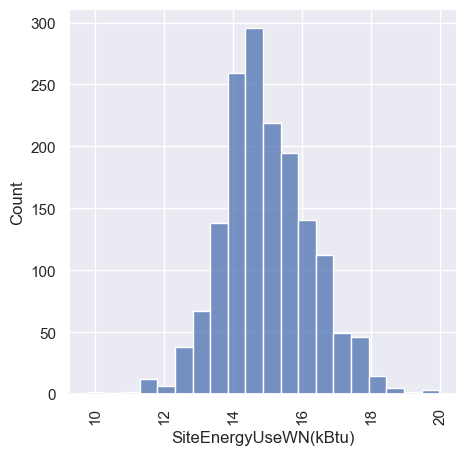

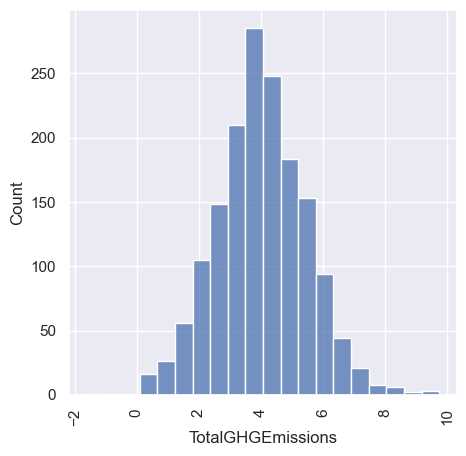

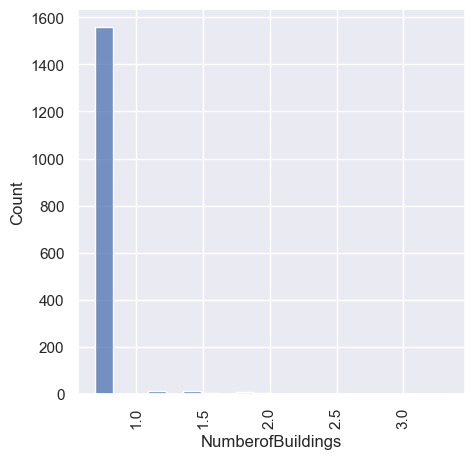

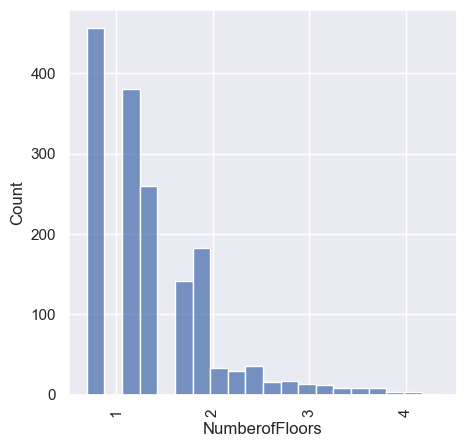

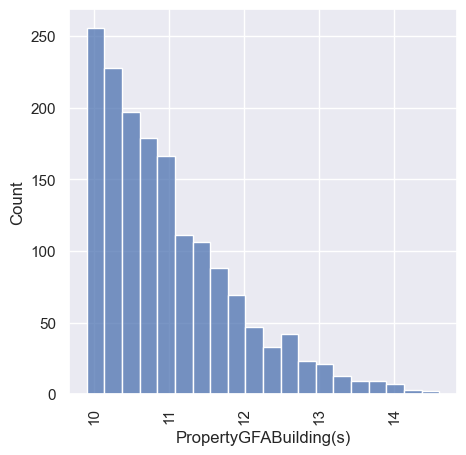

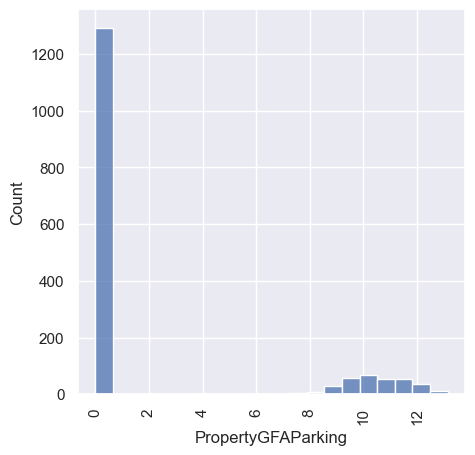

In [32]:
for col in col_log:
    plt.figure(figsize = (5,5))#,constrained_layout=True)
    #plt.suptitle("Distribution de la surface par étage", size=20, y=1)
    plt.xticks(rotation = 90)
    sns.histplot(df1_log[col], bins =20)#, stat='percent' #, kde=True)

A noter que le passage au log de certaines features (nb d'étage, nb de building, par ex) ne 'normalise'. Mais après testing avec et sans passage au log, pas de différence dans les résultats des différents gridSerarchCV. Pour raison de simplicité, je suis resté sur cette version mais idéalement il vaut mieux cibler les colonnes passées au log.

### 3.2.1 GridSearch sur base de df1_log

#### 3.2.1.1 Reconstitution des dataset X_log et y_log

In [248]:
X_log=df1_log.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'],axis=1).select_dtypes(include=np.number)
X_log

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore
0,47.61220,-122.33799,1927,0.693147,2.564949,0.000000,11.390023,60.0
1,47.61317,-122.33393,1996,0.693147,2.484907,9.620129,11.390792,61.0
2,47.61393,-122.33810,1969,0.693147,3.737670,12.189532,13.540275,43.0
3,47.61412,-122.33664,1926,0.693147,2.397895,0.000000,11.023878,56.0
4,47.61375,-122.34047,1980,0.693147,2.944439,11.034906,11.640272,75.0
...,...,...,...,...,...,...,...,...
1604,47.62497,-122.33883,2015,0.693147,1.945910,11.350748,12.469448,NaN
1605,47.66127,-122.31256,1962,0.693147,0.693147,0.000000,11.128336,NaN
1606,47.70541,-122.32232,2005,0.693147,0.693147,0.000000,9.933871,NaN
1607,47.63228,-122.31574,1912,0.693147,0.693147,0.000000,10.062455,NaN


In [249]:
y_log=df1_log['SiteEnergyUseWN(kBtu)']
y_log.size

1609

#### 3.2.1.2 GridSearchCv

Essayons de voir si certains estimateurs se démarquent...
D'abord avec uniquement target au log...

In [252]:
grid.fit(X,y_log)
res=result(grid,log_target=1,transf_feat=0,features='')
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
23,1.13,0.03,0.03,0.01,RandomForestRegressor(),StandardScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.46,0.13,1,0.95,0.00,-0.57,0.06,1,-0.21,0.00,-0.63,0.13,1,-0.09,0.00,1,0,
24,1.16,0.11,0.04,0.01,RandomForestRegressor(),passthrough,"{'estimator': RandomForestRegressor(), 'scaler...",0.46,0.13,2,0.95,0.00,-0.57,0.06,3,-0.21,0.00,-0.64,0.13,2,-0.09,0.00,1,0,
22,1.10,0.02,0.03,0.00,RandomForestRegressor(),RobustScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.46,0.13,3,0.95,0.00,-0.57,0.06,2,-0.21,0.00,-0.64,0.13,3,-0.09,0.00,1,0,
20,1.09,0.01,0.03,0.01,RandomForestRegressor(),MinMaxScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.45,0.13,4,0.95,0.00,-0.57,0.06,4,-0.21,0.00,-0.64,0.13,4,-0.09,0.00,1,0,
33,0.32,0.01,0.06,0.00,SVR(),StandardScaler(),"{'estimator': SVR(), 'scaler': StandardScaler()}",0.42,0.13,5,0.66,0.01,-0.59,0.06,5,-0.52,0.01,-0.68,0.12,5,-0.58,0.01,1,0,
21,1.32,0.02,0.04,0.01,RandomForestRegressor(),Normalizer(),"{'estimator': RandomForestRegressor(), 'scaler...",0.41,0.13,6,0.94,0.00,-0.60,0.07,6,-0.22,0.00,-0.70,0.14,6,-0.10,0.00,1,0,
34,0.30,0.05,0.05,0.02,SVR(),passthrough,"{'estimator': SVR(), 'scaler': 'passthrough'}",0.37,0.14,7,0.57,0.02,-0.62,0.06,7,-0.61,0.01,-0.73,0.14,7,-0.71,0.02,1,0,
26,0.10,0.01,0.02,0.00,KNeighborsRegressor(),Normalizer(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.33,0.11,8,0.68,0.01,-0.67,0.05,10,-0.55,0.01,-0.79,0.10,9,-0.53,0.01,1,0,
30,0.36,0.01,0.06,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.32,0.15,9,0.58,0.02,-0.66,0.04,9,-0.62,0.01,-0.78,0.10,8,-0.71,0.02,1,0,
1,0.10,0.02,0.02,0.00,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.32,0.12,10,0.54,0.01,-0.66,0.05,8,-0.65,0.01,-0.81,0.13,10,-0.78,0.01,1,0,


En passant la target au log, le R² passe de 0.23 à 0.46 (RandomForest avec différents scalers)

In [251]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
35,1.12,0.02,0.03,0.01,RandomForestRegressor(),StandardScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",4.600000e-01,1.300000e-01,1,9.500000e-01,0.000000e+00,-5.700000e-01,6.000000e-02,1,-2.100000e-01,0.000000e+00,-6.300000e-01,1.400000e-01,1,-9.000000e-02,0.000000e+00,1,0,
36,1.09,0.01,0.03,0.01,RandomForestRegressor(),RobustScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",4.600000e-01,1.300000e-01,2,9.500000e-01,0.000000e+00,-5.700000e-01,6.000000e-02,3,-2.100000e-01,0.000000e+00,-6.300000e-01,1.300000e-01,2,-9.000000e-02,0.000000e+00,1,0,
37,1.17,0.09,0.04,0.00,RandomForestRegressor(),passthrough,"{'estimator': RandomForestRegressor(), 'scaler...",4.600000e-01,1.300000e-01,3,9.500000e-01,0.000000e+00,-5.700000e-01,6.000000e-02,2,-2.100000e-01,0.000000e+00,-6.400000e-01,1.300000e-01,3,-9.000000e-02,0.000000e+00,1,0,
38,1.11,0.01,0.03,0.00,RandomForestRegressor(),MinMaxScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",4.500000e-01,1.200000e-01,4,9.500000e-01,0.000000e+00,-5.700000e-01,6.000000e-02,4,-2.100000e-01,0.000000e+00,-6.400000e-01,1.200000e-01,4,-9.000000e-02,0.000000e+00,1,0,
39,0.32,0.01,0.06,0.00,SVR(),StandardScaler(),"{'estimator': SVR(), 'scaler': StandardScaler()}",4.200000e-01,1.300000e-01,5,6.600000e-01,1.000000e-02,-5.900000e-01,6.000000e-02,5,-5.200000e-01,1.000000e-02,-6.800000e-01,1.200000e-01,5,-5.800000e-01,1.000000e-02,1,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.14,0.05,0.02,0.01,SGDRegressor(),Normalizer(),"{'estimator': SGDRegressor(), 'scaler': Normal...",-6.600000e-01,1.270000e+00,33,2.000000e-02,1.000000e-02,-8.511784e+06,2.927680e+06,33,-8.322296e+06,7.006915e+05,-4.972388e+14,7.674900e+14,28,-4.891304e+14,8.470896e+13,0,0,
33,0.13,0.01,0.02,0.01,SGDRegressor(),RobustScaler(),"{'estimator': SGDRegressor(), 'scaler': Robust...",-5.513572e+22,7.830970e+22,34,-4.394893e+22,6.148136e+22,-7.061720e+17,7.957700e+17,34,-1.133544e+18,9.013454e+17,-6.858459e+36,1.092049e+37,34,-2.362655e+37,3.361664e+37,0,0,
34,0.13,0.01,0.02,0.01,SGDRegressor(),passthrough,"{'estimator': SGDRegressor(), 'scaler': 'passt...",-3.633304e+24,5.935487e+24,35,-3.832180e+24,5.769544e+24,-1.091324e+19,1.546344e+19,35,-1.391986e+19,1.632324e+19,-9.086676e+38,2.094606e+39,35,-1.768909e+39,2.856252e+39,0,0,
68,0.13,0.01,0.02,0.01,SGDRegressor(),RobustScaler(),"{'estimator': SGDRegressor(), 'scaler': Robust...",-9.853307e+36,1.453802e+37,34,-2.427418e+37,3.218987e+37,-8.832018e+17,9.118485e+17,34,-1.483412e+18,1.226705e+18,-1.294563e+37,2.103393e+37,34,-4.151630e+37,5.545434e+37,1,0,


Puis en passant les features au log...

In [253]:
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log')
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
32,0.31,0.01,0.06,0.00,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",4.800000e-01,1.400000e-01,1,6.500000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,1,-5.200000e-01,1.000000e-02,-6.100000e-01,1.400000e-01,1,-5.800000e-01,1.000000e-02,1,1,log
1,0.12,0.02,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",4.800000e-01,1.400000e-01,2,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,2,-5.400000e-01,1.000000e-02,-6.100000e-01,1.500000e-01,2,-6.000000e-01,2.000000e-02,1,1,log
14,0.12,0.01,0.02,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",4.700000e-01,1.400000e-01,3,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,3,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,3,-6.100000e-01,2.000000e-02,1,1,log
30,0.34,0.02,0.06,0.01,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",4.700000e-01,1.300000e-01,4,6.600000e-01,2.000000e-02,-5.500000e-01,7.000000e-02,4,-5.100000e-01,1.000000e-02,-6.200000e-01,1.400000e-01,11,-5.700000e-01,2.000000e-02,1,1,log
12,0.13,0.01,0.02,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",4.700000e-01,1.500000e-01,5,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,10,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,4,-6.100000e-01,2.000000e-02,1,1,log
13,0.13,0.01,0.02,0.00,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",4.700000e-01,1.500000e-01,6,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,5,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,5,-6.100000e-01,2.000000e-02,1,1,log
0,0.12,0.01,0.02,0.01,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",4.700000e-01,1.500000e-01,7,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,7,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,6,-6.100000e-01,2.000000e-02,1,1,log
2,0.13,0.02,0.02,0.00,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",4.700000e-01,1.500000e-01,8,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,6,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,7,-6.100000e-01,2.000000e-02,1,1,log
4,0.12,0.01,0.02,0.00,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",4.700000e-01,1.500000e-01,9,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,9,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,8,-6.100000e-01,2.000000e-02,1,1,log
3,0.13,0.02,0.02,0.01,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",4.700000e-01,1.500000e-01,9,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,7,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,9,-6.100000e-01,2.000000e-02,1,1,log


Légère amélioration: R² passe de 0.46 à .48  (SVR et LinReg)

In [38]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
70,0.33,0.01,0.06,0.00,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",4.800000e-01,1.400000e-01,1,6.500000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,1,-5.200000e-01,1.000000e-02,-6.100000e-01,1.400000e-01,1,-5.800000e-01,1.000000e-02,1,1,log
71,0.14,0.03,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",4.800000e-01,1.400000e-01,2,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,2,-5.400000e-01,1.000000e-02,-6.100000e-01,1.500000e-01,2,-6.000000e-01,2.000000e-02,1,1,log
74,0.14,0.02,0.02,0.01,SGDRegressor(),RobustScaler(),"{'estimator': SGDRegressor(), 'scaler': Robust...",4.700000e-01,1.400000e-01,5,6.300000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,3,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,4,-6.100000e-01,2.000000e-02,1,1,log
82,0.13,0.01,0.02,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",4.700000e-01,1.500000e-01,13,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,11,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,13,-6.100000e-01,2.000000e-02,1,1,log
72,0.13,0.01,0.02,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",4.700000e-01,1.400000e-01,3,6.400000e-01,2.000000e-02,-5.500000e-01,8.000000e-02,4,-5.500000e-01,1.000000e-02,-6.200000e-01,1.500000e-01,3,-6.100000e-01,2.000000e-02,1,1,log
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,0.12,0.01,0.02,0.00,SGDRegressor(),RobustScaler(),"{'estimator': SGDRegressor(), 'scaler': Robust...",-1.898281e+22,2.028166e+22,34,-1.873393e+22,2.693176e+22,-4.820121e+17,6.461458e+17,34,-6.695916e+17,5.539162e+17,-4.648906e+36,8.407676e+36,34,-8.449314e+36,1.264230e+37,0,0,
34,0.12,0.02,0.02,0.00,SGDRegressor(),passthrough,"{'estimator': SGDRegressor(), 'scaler': 'passt...",-1.964330e+24,3.300005e+24,35,-8.540438e+23,1.733287e+24,-6.501559e+18,5.695707e+18,35,-7.514930e+18,7.827692e+18,-2.244699e+38,2.854927e+38,35,-4.601893e+38,9.465440e+38,0,0,
104,0.14,0.02,0.02,0.01,SGDRegressor(),passthrough,"{'estimator': SGDRegressor(), 'scaler': 'passt...",-2.215697e+30,2.810192e+30,35,-1.392443e+30,1.454911e+30,-1.270368e+15,8.591584e+14,35,-1.273109e+15,8.616856e+14,-2.353266e+30,2.469153e+30,35,-2.364624e+30,2.483256e+30,1,1,log
68,0.14,0.01,0.02,0.01,SGDRegressor(),RobustScaler(),"{'estimator': SGDRegressor(), 'scaler': Robust...",-1.588434e+36,1.530503e+36,34,-4.002778e+36,4.275793e+36,-3.892169e+17,3.102884e+17,34,-6.568328e+17,4.280666e+17,-2.038269e+36,2.128677e+36,34,-6.829535e+36,7.365572e+36,1,0,


## 3.4 Amélioration du modèle en encodant les valeurs catégorielles

Dans le pipeline, création d'un transformer qui servira à encoder les variables catégorielles via OneHotEncoder 

### 3.4.1 Reconstitution du dataset X_log avec les variables catégorielles

In [263]:
X_log=df1_log.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'],axis=1)
X_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,0.693147,2.564949,0.000000,11.390023,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,0.693147,2.484907,9.620129,11.390792,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,0.693147,3.737670,12.189532,13.540275,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,0.693147,2.397895,0.000000,11.023878,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,0.693147,2.944439,11.034906,11.640272,75.0
...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,LAKE UNION,0.693147,1.945910,11.350748,12.469448,NaN
1605,University,47.66127,-122.31256,1962,NORTHEAST,0.693147,0.693147,0.000000,11.128336,NaN
1606,Entertainment,47.70541,-122.32232,2005,NORTH,0.693147,0.693147,0.000000,9.933871,NaN
1607,Entertainment,47.63228,-122.31574,1912,EAST,0.693147,0.693147,0.000000,10.062455,NaN


### 3.4.2 Adaptation du pipeline

In [264]:
cat_feat=X_log.select_dtypes(exclude=np.number).columns.to_list()
cat_feat

['PrimaryPropertyType', 'Neighborhood']

In [265]:
num_feat=X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore']

Création d'un transformer dans le pipeline:

In [266]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False),['Neighborhood','PrimaryPropertyType']),
                               ('num','passthrough',num_feat)
                               ]
                             )
transformer

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['Neighborhood', 'PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'ENERGYSTARScore'])])

In [267]:
pipeline=Pipeline([
    ('preprocessor',transformer),
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LinearRegression())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Neighborhood',
                                                   'PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('estimator', Line

In [268]:
param_grid={
    'scaler':[MinMaxScaler(), Normalizer(), RobustScaler(), StandardScaler(),'passthrough'], 
    'estimator':[LinearRegression(),SGDRegressor(), Ridge(), Lasso(), RandomForestRegressor(),KNeighborsRegressor(), SVR()]
}

In [271]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot')
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
1,0.16,0.02,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.61,0.14,1,0.76,0.01,-0.46,0.07,1,-0.44,0.01,-0.44,0.13,2,-0.41,0.01,1,1,log + OneHot
12,0.18,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.61,0.14,2,0.76,0.01,-0.46,0.07,4,-0.45,0.01,-0.44,0.13,1,-0.41,0.01,1,1,log + OneHot
10,0.17,0.01,0.03,0.00,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.61,0.14,3,0.76,0.01,-0.46,0.07,3,-0.45,0.01,-0.44,0.13,4,-0.41,0.01,1,1,log + OneHot
14,0.17,0.02,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.61,0.15,4,0.76,0.01,-0.46,0.07,2,-0.45,0.01,-0.44,0.13,3,-0.41,0.01,1,1,log + OneHot
13,0.17,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.61,0.14,5,0.76,0.01,-0.47,0.07,5,-0.45,0.01,-0.44,0.13,5,-0.41,0.01,1,1,log + OneHot
4,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.61,0.14,6,0.76,0.01,-0.47,0.07,6,-0.45,0.01,-0.44,0.13,6,-0.41,0.01,1,1,log + OneHot
2,0.18,0.02,0.03,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.61,0.14,7,0.76,0.01,-0.47,0.07,8,-0.45,0.01,-0.44,0.13,7,-0.41,0.01,1,1,log + OneHot
0,0.15,0.01,0.03,0.01,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.61,0.14,8,0.76,0.01,-0.47,0.07,7,-0.45,0.01,-0.45,0.13,8,-0.41,0.01,1,1,log + OneHot
3,0.18,0.03,0.03,0.01,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",0.61,0.14,9,0.76,0.01,-0.47,0.07,10,-0.45,0.01,-0.45,0.13,9,-0.41,0.01,1,1,log + OneHot
8,0.17,0.01,0.03,0.00,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.61,0.14,10,0.76,0.01,-0.47,0.07,9,-0.45,0.01,-0.45,0.13,10,-0.41,0.01,1,1,log + OneHot


Avec encodage des variables catégorielles (Usage du bâtiment et quartier), le coeff  R² passe de 0.48 à 0.62:
(SGD Regression avec StandardScaler) et à 0.61 avec Ridge et LinReg

In [272]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
73,0.17,0.02,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.61,0.15,4,0.76,0.01,-0.46,0.07,2,-0.45,0.01,-0.44,0.13,3,-0.41,0.01,1,1,log + OneHot
70,0.16,0.02,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.61,0.14,1,0.76,0.01,-0.46,0.07,1,-0.44,0.01,-0.44,0.13,2,-0.41,0.01,1,1,log + OneHot
71,0.18,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.61,0.14,2,0.76,0.01,-0.46,0.07,4,-0.45,0.01,-0.44,0.13,1,-0.41,0.01,1,1,log + OneHot
72,0.17,0.01,0.03,0.00,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.61,0.14,3,0.76,0.01,-0.46,0.07,3,-0.45,0.01,-0.44,0.13,4,-0.41,0.01,1,1,log + OneHot
74,0.17,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.61,0.14,5,0.76,0.01,-0.47,0.07,5,-0.45,0.01,-0.44,0.13,5,-0.41,0.01,1,1,log + OneHot


## 3.5 Utlisation des features parking et type d'energie (en booléen)

Sur base du dataV2, constitué dans le notebook 1 dans lequel j'ai transformé la superficie du parking en indicateur 'has_parking?' et les conso de gaz, elec et steam en booléen

In [273]:
df2_log=df2.copy()

In [274]:
col_log

['SiteEnergyUseWN(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking']

Suppression de PropertyGFAParking' de la liste des features à passer au col


In [275]:
col_log=['SiteEnergyUseWN(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)']

In [276]:
for col in col_log:
    df2_log[col]=np.log1p(df2[col])
df2_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,has_parking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),Steam_use,Electricity_use,Gas_use,TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,0.693147,2.564949,0,11.390023,15.824652,1,1,1,5.525373,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,0.693147,2.484907,1,11.390792,15.974742,0,1,1,5.693261,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,0.693147,3.737670,1,13.540275,18.118725,1,1,1,7.645053,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,0.693147,2.397895,0,11.023878,15.753792,1,1,1,5.660979,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,0.693147,2.944439,1,11.640272,16.500395,0,1,1,6.226556,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,LAKE UNION,0.693147,1.945910,1,12.469448,17.530998,0,1,1,6.908815,NaN
1605,University,47.66127,-122.31256,1962,NORTHEAST,0.693147,0.693147,0,11.128336,14.972650,0,1,0,3.142858,NaN
1606,Entertainment,47.70541,-122.32232,2005,NORTH,0.693147,0.693147,0,9.933871,13.364472,0,1,0,1.693779,NaN
1607,Entertainment,47.63228,-122.31574,1912,EAST,0.693147,0.693147,0,10.062455,15.720053,0,1,1,5.561527,NaN


### 3.5.1 Adaptation du dataset X_log avec les nouvelles variables

In [277]:
X_log=df2_log.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'],axis=1)
X_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,has_parking,PropertyGFABuilding(s),Steam_use,Electricity_use,Gas_use,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,0.693147,2.564949,0,11.390023,1,1,1,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,0.693147,2.484907,1,11.390792,0,1,1,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,0.693147,3.737670,1,13.540275,1,1,1,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,0.693147,2.397895,0,11.023878,1,1,1,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,0.693147,2.944439,1,11.640272,0,1,1,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,LAKE UNION,0.693147,1.945910,1,12.469448,0,1,1,NaN
1605,University,47.66127,-122.31256,1962,NORTHEAST,0.693147,0.693147,0,11.128336,0,1,0,NaN
1606,Entertainment,47.70541,-122.32232,2005,NORTH,0.693147,0.693147,0,9.933871,0,1,0,NaN
1607,Entertainment,47.63228,-122.31574,1912,EAST,0.693147,0.693147,0,10.062455,0,1,1,NaN


### 3.5.2 Adaptation du pipeline

In [278]:
num_feat=X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'has_parking',
 'PropertyGFABuilding(s)',
 'Steam_use',
 'Electricity_use',
 'Gas_use',
 'ENERGYSTARScore']

In [279]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False),cat_feat),
                               ('num','passthrough',num_feat)
                               ]
                             )

In [280]:
pipeline=Pipeline([
    ('preprocessor',transformer),
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LinearRegression())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                            

In [281]:
param_grid

{'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'],
 'estimator': [LinearRegression(),
  SGDRegressor(),
  Ridge(),
  Lasso(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
  SVR()]}

In [283]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_bool')
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
30,0.43,0.01,0.08,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.65,0.10,1,0.82,0.01,-0.44,0.04,1,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool
12,0.18,0.01,0.04,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.65,0.11,2,0.78,0.01,-0.45,0.05,3,-0.43,0.01,-0.41,0.11,3,-0.37,0.01,1,1,log + OneHot + NRJ_bool
14,0.16,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.11,3,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool
10,0.16,0.01,0.04,0.00,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.65,0.11,4,0.78,0.01,-0.45,0.05,4,-0.43,0.01,-0.41,0.11,4,-0.37,0.01,1,1,log + OneHot + NRJ_bool
1,0.17,0.03,0.04,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.65,0.10,5,0.78,0.01,-0.45,0.05,5,-0.43,0.01,-0.41,0.11,5,-0.37,0.01,1,1,log + OneHot + NRJ_bool
13,0.17,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.65,0.10,6,0.78,0.01,-0.45,0.05,6,-0.43,0.01,-0.41,0.11,6,-0.37,0.01,1,1,log + OneHot + NRJ_bool
4,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.65,0.10,7,0.78,0.01,-0.45,0.05,7,-0.43,0.01,-0.41,0.11,7,-0.37,0.01,1,1,log + OneHot + NRJ_bool
2,0.19,0.02,0.04,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.65,0.10,8,0.78,0.01,-0.45,0.05,8,-0.43,0.01,-0.41,0.11,8,-0.37,0.01,1,1,log + OneHot + NRJ_bool
0,0.15,0.01,0.03,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.65,0.10,9,0.78,0.01,-0.45,0.05,9,-0.43,0.01,-0.41,0.11,9,-0.37,0.01,1,1,log + OneHot + NRJ_bool
3,0.18,0.03,0.03,0.00,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",0.65,0.10,10,0.78,0.01,-0.45,0.05,10,-0.43,0.01,-0.41,0.11,10,-0.37,0.01,1,1,log + OneHot + NRJ_bool


Avec l'utilisation des type de conso des batiment le R² passe de 0.62 à 0,65:
- SVR avec MinMax
- Ridge avec ou sans scaler
- Reg Lineaire avec ou sans scaler
- SGD Reg avec StandardScaler

In [284]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
105,0.43,0.01,0.08,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.65,0.10,1,0.82,0.01,-0.44,0.04,1,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool
107,0.16,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.11,3,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool
109,0.17,0.03,0.04,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.65,0.10,5,0.78,0.01,-0.45,0.05,5,-0.43,0.01,-0.41,0.11,5,-0.37,0.01,1,1,log + OneHot + NRJ_bool
110,0.17,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.65,0.10,6,0.78,0.01,-0.45,0.05,6,-0.43,0.01,-0.41,0.11,6,-0.37,0.01,1,1,log + OneHot + NRJ_bool
111,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.65,0.10,7,0.78,0.01,-0.45,0.05,7,-0.43,0.01,-0.41,0.11,7,-0.37,0.01,1,1,log + OneHot + NRJ_bool
112,0.19,0.02,0.04,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.65,0.10,8,0.78,0.01,-0.45,0.05,8,-0.43,0.01,-0.41,0.11,8,-0.37,0.01,1,1,log + OneHot + NRJ_bool
113,0.15,0.01,0.03,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.65,0.10,9,0.78,0.01,-0.45,0.05,9,-0.43,0.01,-0.41,0.11,9,-0.37,0.01,1,1,log + OneHot + NRJ_bool
114,0.18,0.03,0.03,0.00,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",0.65,0.10,10,0.78,0.01,-0.45,0.05,10,-0.43,0.01,-0.41,0.11,10,-0.37,0.01,1,1,log + OneHot + NRJ_bool
115,0.17,0.01,0.03,0.00,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.65,0.11,11,0.78,0.01,-0.46,0.06,11,-0.43,0.01,-0.41,0.11,11,-0.37,0.01,1,1,log + OneHot + NRJ_bool
106,0.18,0.01,0.04,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.65,0.11,2,0.78,0.01,-0.45,0.05,3,-0.43,0.01,-0.41,0.11,3,-0.37,0.01,1,1,log + OneHot + NRJ_bool


## 3.6 Amélioration des hyperparamètres

### 3.5.1 SVR 

In [285]:
param_grid={'scaler': [MinMaxScaler(),
  ],
 'estimator': [SVR(),
  ],
  'estimator__epsilon':[0,0.01, 0.05,0.2],
  'estimator__C':[1,2,3,5 ] 
           }

In [286]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1, verbose=2,return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_bool')
res.head(5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__C,param_estimator__epsilon,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
4,0.54,0.05,0.11,0.02,"SVR(C=2, epsilon=0)",2,0,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,1,0.84,0.01,-0.44,0.05,6,-0.31,0.0,-0.4,0.1,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool
2,0.50,0.07,0.09,0.01,"SVR(C=2, epsilon=0)",1,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,2,0.82,0.01,-0.44,0.04,3,-0.35,0.0,-0.4,0.1,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool
1,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",1,0.01,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,3,0.82,0.01,-0.44,0.05,1,-0.34,0.0,-0.4,0.1,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool
5,0.52,0.02,0.10,0.01,"SVR(C=2, epsilon=0)",2,0.01,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,4,0.84,0.01,-0.44,0.05,5,-0.31,0.0,-0.4,0.1,5,-0.27,0.01,1,1,log + OneHot + NRJ_bool
6,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",2,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,5,0.84,0.01,-0.44,0.05,4,-0.32,0.0,-0.4,0.1,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool


En améliorant certains hyperparamètres du SVR on passe R²= 0.65 à 0.66

In [287]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon
144,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,5,0.84,0.01,-0.44,0.05,4,-0.32,0.0,-0.4,0.10,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05
142,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,3,0.82,0.01,-0.44,0.05,1,-0.34,0.0,-0.4,0.10,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01
140,0.54,0.05,0.11,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,1,0.84,0.01,-0.44,0.05,6,-0.31,0.0,-0.4,0.10,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0
146,0.53,0.06,0.10,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,7,0.82,0.01,-0.44,0.05,2,-0.34,0.0,-0.4,0.10,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0
145,0.74,0.36,0.08,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,6,0.84,0.01,-0.44,0.05,7,-0.34,0.0,-0.4,0.09,2,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.2


### 3.5.2 Ridge

ajout de de l'hyperparamètre alpha dans le param_grid:

In [300]:
param_grid={'scaler': [MinMaxScaler(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'
  ],
 'estimator': [Ridge(),
  ],
  'estimator__alpha':[5,100,200,500]
           }

In [301]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1, verbose=2,return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_bool')
res.head(5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
1,0.20,0.02,0.03,0.00,Ridge(alpha=5),5,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.11,1,0.78,0.01,-0.45,0.05,1,-0.43,0.01,-0.40,0.11,1,-0.37,0.01,1,1,log + OneHot + NRJ_bool
3,0.17,0.02,0.03,0.00,Ridge(alpha=5),5,passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.11,2,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool
2,0.18,0.03,0.03,0.01,Ridge(alpha=5),5,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.10,3,0.78,0.01,-0.45,0.05,3,-0.43,0.01,-0.41,0.11,3,-0.37,0.01,1,1,log + OneHot + NRJ_bool
6,0.17,0.01,0.03,0.01,Ridge(alpha=5),100,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.64,0.10,4,0.78,0.01,-0.46,0.05,4,-0.44,0.01,-0.41,0.10,5,-0.38,0.01,1,1,log + OneHot + NRJ_bool
0,0.16,0.01,0.03,0.00,Ridge(alpha=5),5,MinMaxScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.64,0.10,5,0.77,0.01,-0.46,0.05,5,-0.44,0.01,-0.41,0.10,4,-0.38,0.01,1,1,log + OneHot + NRJ_bool


In [304]:
model=grid.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                            

Pas d'amélioration

In [290]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha
142,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,3,0.82,0.01,-0.44,0.05,1,-0.34,0.0,-0.4,0.10,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN
140,0.54,0.05,0.11,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,1,0.84,0.01,-0.44,0.05,6,-0.31,0.0,-0.4,0.10,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN
146,0.53,0.06,0.10,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,7,0.82,0.01,-0.44,0.05,2,-0.34,0.0,-0.4,0.10,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN
145,0.74,0.36,0.08,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,6,0.84,0.01,-0.44,0.05,7,-0.34,0.0,-0.4,0.09,2,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN
144,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,5,0.84,0.01,-0.44,0.05,4,-0.32,0.0,-0.4,0.10,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN


### 3.5.3 SGD regressor

In [291]:
param_grid={'scaler': [
  StandardScaler(),
  'passthrough'
  ],
 'estimator': [SGDRegressor(),
  ],
  'estimator__eta0':np.linspace(0.01,0.5,11)
           }

In [292]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1, verbose=2,return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_bool')
res.head(5)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__eta0,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.17,0.02,0.03,0.01,SGDRegressor(),0.01,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",6.500000e-01,1.100000e-01,1,7.800000e-01,1.000000e-02,-4.500000e-01,5.000000e-02,1,-4.300000e-01,1.000000e-02,-4.100000e-01,1.100000e-01,1,-3.700000e-01,1.000000e-02,1,1,log + OneHot + NRJ_bool
2,0.17,0.02,0.03,0.01,SGDRegressor(),0.059,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.089922e+15,6.228107e+15,2,-3.280849e+15,7.236496e+15,-4.180270e+06,9.197035e+06,2,-4.785697e+06,7.941955e+06,-1.862215e+15,5.520906e+15,2,-5.611197e+15,1.252420e+16,1,1,log + OneHot + NRJ_bool
4,0.17,0.02,0.03,0.01,SGDRegressor(),0.108,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.515397e+21,6.878073e+21,3,-8.669705e+21,7.555330e+21,-1.131782e+10,1.200240e+10,3,-1.237915e+10,9.742503e+09,-2.860660e+21,7.745979e+21,3,-1.448571e+22,1.273440e+22,1,1,log + OneHot + NRJ_bool
10,0.20,0.03,0.03,0.01,SGDRegressor(),0.255,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.412950e+23,2.523728e+23,4,-8.897743e+22,7.588282e+22,-1.254212e+11,1.321707e+11,6,-1.000470e+11,8.527757e+10,-2.155430e+23,4.296227e+23,5,-1.477495e+23,1.240244e+23,1,1,log + OneHot + NRJ_bool
6,0.17,0.01,0.03,0.01,SGDRegressor(),0.157,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.579123e+23,3.889471e+23,5,-5.816163e+22,5.513391e+22,-8.485278e+10,7.418194e+10,4,-6.885157e+10,2.794709e+10,-2.547929e+23,6.670435e+23,6,-9.746438e+22,9.274485e+22,1,1,log + OneHot + NRJ_bool


Pas d'amélioration

In [293]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
146,0.53,0.06,0.10,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,7,0.82,0.01,-0.44,0.05,2,-0.34,0.0,-0.4,0.10,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN
145,0.74,0.36,0.08,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,6,0.84,0.01,-0.44,0.05,7,-0.34,0.0,-0.4,0.09,2,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN
144,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,5,0.84,0.01,-0.44,0.05,4,-0.32,0.0,-0.4,0.10,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN
143,0.52,0.02,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,4,0.84,0.01,-0.44,0.05,5,-0.31,0.0,-0.4,0.10,5,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN
142,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,3,0.82,0.01,-0.44,0.05,1,-0.34,0.0,-0.4,0.10,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN


### 3.5.3 Amélioration hyperparam pour RandomForest

In [294]:
param_grid={'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'
  ],
 'estimator': [RandomForestRegressor(),
  ],
  'estimator__n_estimators':[200,300,500,]
           }

In [295]:
if DISPLAY:
    grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1, verbose=2,return_train_score=True,
    refit='r2')
    grid.fit(X_log,y_log)
    res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_bool')
res.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__eta0,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.17,0.02,0.03,0.01,SGDRegressor(),0.01,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",6.500000e-01,1.100000e-01,1,7.800000e-01,1.000000e-02,-4.500000e-01,5.000000e-02,1,-4.300000e-01,1.000000e-02,-4.100000e-01,1.100000e-01,1,-3.700000e-01,1.000000e-02,1,1,log + OneHot + NRJ_bool
2,0.17,0.02,0.03,0.01,SGDRegressor(),0.059,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.089922e+15,6.228107e+15,2,-3.280849e+15,7.236496e+15,-4.180270e+06,9.197035e+06,2,-4.785697e+06,7.941955e+06,-1.862215e+15,5.520906e+15,2,-5.611197e+15,1.252420e+16,1,1,log + OneHot + NRJ_bool
4,0.17,0.02,0.03,0.01,SGDRegressor(),0.108,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.515397e+21,6.878073e+21,3,-8.669705e+21,7.555330e+21,-1.131782e+10,1.200240e+10,3,-1.237915e+10,9.742503e+09,-2.860660e+21,7.745979e+21,3,-1.448571e+22,1.273440e+22,1,1,log + OneHot + NRJ_bool
10,0.20,0.03,0.03,0.01,SGDRegressor(),0.255,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.412950e+23,2.523728e+23,4,-8.897743e+22,7.588282e+22,-1.254212e+11,1.321707e+11,6,-1.000470e+11,8.527757e+10,-2.155430e+23,4.296227e+23,5,-1.477495e+23,1.240244e+23,1,1,log + OneHot + NRJ_bool
6,0.17,0.01,0.03,0.01,SGDRegressor(),0.157,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.579123e+23,3.889471e+23,5,-5.816163e+22,5.513391e+22,-8.485278e+10,7.418194e+10,4,-6.885157e+10,2.794709e+10,-2.547929e+23,6.670435e+23,6,-9.746438e+22,9.274485e+22,1,1,log + OneHot + NRJ_bool


Pas d'amélioration en fonction du nombre d'arbres choisi

In [73]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
179,0.51,0.03,0.09,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,5,0.84,0.01,-0.44,0.05,4,-0.32,0.0,-0.4,0.1,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN
181,0.52,0.03,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,7,0.82,0.01,-0.44,0.05,2,-0.34,0.0,-0.4,0.1,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN
175,0.55,0.03,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,1,0.84,0.01,-0.44,0.05,6,-0.31,0.0,-0.4,0.1,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN
176,0.47,0.02,0.09,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,2,0.82,0.01,-0.44,0.04,3,-0.35,0.0,-0.4,0.1,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN
177,0.53,0.05,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.1,3,0.82,0.01,-0.44,0.05,1,-0.34,0.0,-0.4,0.1,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN


## 3.7 Conclusion: meilleur modèle

In [296]:
RES.sort_values("mean_test_r2", ascending =False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
146,0.53,0.06,0.10,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,7,0.82,0.01,-0.44,0.05,2,-0.34,0.00,-0.40,0.10,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN
145,0.74,0.36,0.08,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,6,0.84,0.01,-0.44,0.05,7,-0.34,0.00,-0.40,0.09,2,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN
144,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,5,0.84,0.01,-0.44,0.05,4,-0.32,0.00,-0.40,0.10,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN
143,0.52,0.02,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,4,0.84,0.01,-0.44,0.05,5,-0.31,0.00,-0.40,0.10,5,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN
142,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,3,0.82,0.01,-0.44,0.05,1,-0.34,0.00,-0.40,0.10,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN
141,0.50,0.07,0.09,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,2,0.82,0.01,-0.44,0.04,3,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN
140,0.54,0.05,0.11,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,1,0.84,0.01,-0.44,0.05,6,-0.31,0.00,-0.40,0.10,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN
147,0.54,0.12,0.08,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.65,0.10,8,0.85,0.01,-0.45,0.05,8,-0.33,0.00,-0.40,0.09,8,-0.25,0.01,1,1,log + OneHot + NRJ_bool,3,0.2,NaN,NaN
107,0.16,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.11,3,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
111,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.65,0.10,7,0.78,0.01,-0.45,0.05,7,-0.43,0.01,-0.41,0.11,7,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN


In [302]:
RES.sort_values("mean_test_neg_mean_absolute_error", ascending =False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
141,0.50,0.07,0.09,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,2,0.82,0.01,-0.44,0.04,3,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN
105,0.43,0.01,0.08,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.65,0.10,1,0.82,0.01,-0.44,0.04,1,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
146,0.53,0.06,0.10,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,7,0.82,0.01,-0.44,0.05,2,-0.34,0.00,-0.40,0.10,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN
145,0.74,0.36,0.08,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,6,0.84,0.01,-0.44,0.05,7,-0.34,0.00,-0.40,0.09,2,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN
144,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,5,0.84,0.01,-0.44,0.05,4,-0.32,0.00,-0.40,0.10,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN
140,0.54,0.05,0.11,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,1,0.84,0.01,-0.44,0.05,6,-0.31,0.00,-0.40,0.10,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN
142,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,3,0.82,0.01,-0.44,0.05,1,-0.34,0.00,-0.40,0.10,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN
143,0.52,0.02,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,4,0.84,0.01,-0.44,0.05,5,-0.31,0.00,-0.40,0.10,5,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN
111,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.65,0.10,7,0.78,0.01,-0.45,0.05,7,-0.43,0.01,-0.41,0.11,7,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
157,0.17,0.02,0.03,0.01,Ridge(alpha=5),passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.11,2,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,5,NaN


In [ ]:
RES.sort_values("mean_test_neg_mean_squared_error", ascending =False).head(20)

In [309]:
RES.loc[RES['mean_test_r2']>=0.65,:].sort_values("mean_fit_time").head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
113,0.15,0.01,0.03,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.65,0.10,9,0.78,0.01,-0.45,0.05,9,-0.43,0.01,-0.41,0.11,9,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
107,0.16,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.11,3,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
108,0.16,0.01,0.04,0.00,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.65,0.11,4,0.78,0.01,-0.45,0.05,4,-0.43,0.01,-0.41,0.11,4,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
172,0.17,0.02,0.03,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",0.65,0.11,1,0.78,0.01,-0.45,0.05,1,-0.43,0.01,-0.41,0.11,1,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,0.01
109,0.17,0.03,0.04,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.65,0.10,5,0.78,0.01,-0.45,0.05,5,-0.43,0.01,-0.41,0.11,5,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
110,0.17,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.65,0.10,6,0.78,0.01,-0.45,0.05,6,-0.43,0.01,-0.41,0.11,6,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
111,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.65,0.10,7,0.78,0.01,-0.45,0.05,7,-0.43,0.01,-0.41,0.11,7,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
115,0.17,0.01,0.03,0.00,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.65,0.11,11,0.78,0.01,-0.46,0.06,11,-0.43,0.01,-0.41,0.11,11,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
157,0.17,0.02,0.03,0.01,Ridge(alpha=5),passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.11,2,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,5,NaN
106,0.18,0.01,0.04,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.65,0.11,2,0.78,0.01,-0.45,0.05,3,-0.43,0.01,-0.41,0.11,3,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN


Meilleur modèle:

- R² =0.66 (SVR) suivi par SGDReg, LinReg, Ridge (R²=0.65)
- MAE = 0.44 (SVR),  0.45 (SGDReg, LinReg, Ridge)
- MSE = 0.40 (SVR), 0.41 (SGDReg, LinReg, Ridge)


Var r² test score:
- 0.10 pour LinearReg et SVR
- 0.11 pour Ridge, SGD

Fit time = 
- Ridge: 0.17s
- SGD: 0.17s
- LinearReg: 0.17s
- SVR: 0.51s

#### A ce stade je choisis le Ridge comme meilleur modèle (un peu mois performant que SVR mais 3 fois plus rapide)

In [321]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                            

## Représentation graphique de la performance du modèle

### Entrainement du meilleur modèle via Train/Test Split

In [311]:
X_train, X_test,y_train,y_test=train_test_split(X_log,y_log,test_size=0.3)
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (1126, 13)
Test set: (483, 13)
Train target: (1126,)
Test target: (483,)


In [320]:
    #Récupération du param_grid ayant servi pour Ridge
    #param_grid={'scaler': [MinMaxScaler(),
  #RobustScaler(),
  #StandardScaler(),
  #'passthrough'
  #],
 #'estimator': [Ridge(),
 # ],
 # 'estimator__alpha':[5,100,200,500]
 #          }

In [318]:
#grid=GridSearchCV(
#    pipeline,
#    param_grid=param_grid,
#    cv=10,
#    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
#    n_jobs=-1, verbose=2,return_train_score=True,
#    refit='r2')
#grid.fit(X_log,y_log)


In [317]:
#model=grid.best_estimator_
#model

In [312]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                            

In [313]:
model.score(X_train,y_train)

0.7702891831398637

In [314]:
model.score(X_test,y_test)

0.7794412948697257

In [315]:
y_pred=model.predict(X_test)

## Représentations graphiques des résultats (y_test vs y_pred)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


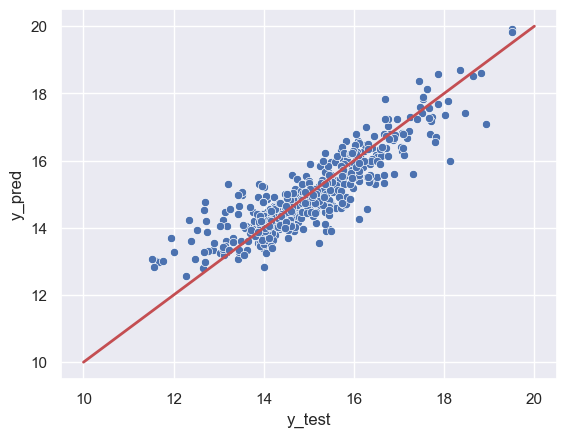

In [322]:
sns.scatterplot(y_test,y_pred).set(xlabel='y_test',ylabel='y_pred')
plt.plot([10.0, 20.0], [10.0, 20.0], 'r-', lw=2)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


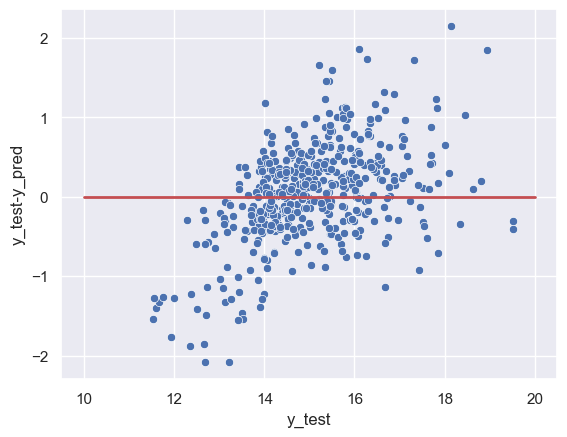

In [323]:
sns.scatterplot(y_test,y_test-y_pred).set(xlabel='y_test',ylabel='y_test-y_pred')
plt.plot([10.0, 20.0], [0.0, 0.0], 'r-', lw=2)

Sur les valeurs plus petites et les plus grandes de y_test, la prédiction est moins bonne. 

Le fait de supprimer les outliers ne ferait que simplifier le pb et non l'améliorer. 

En revanche on pourrait essayer d'ajouter de nouveaux batiments ayant une conso plutôt faible pour améliorer l'entrainement du modèle

Distribution des écarts entre y_test et y_pred:

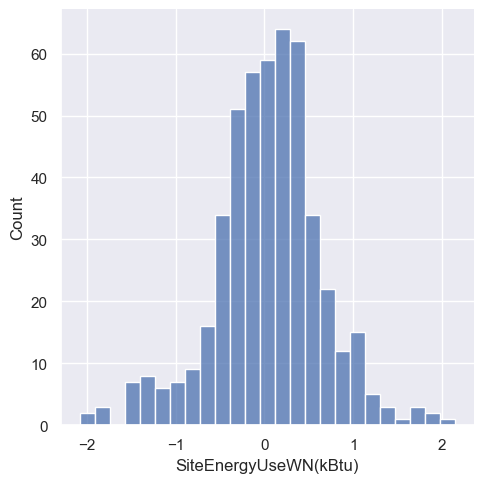

In [324]:
sns.displot(y_test-y_pred)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


[Text(0.5, 0, 'y_test'), Text(0, 0.5, 'y_test/y_pred')]

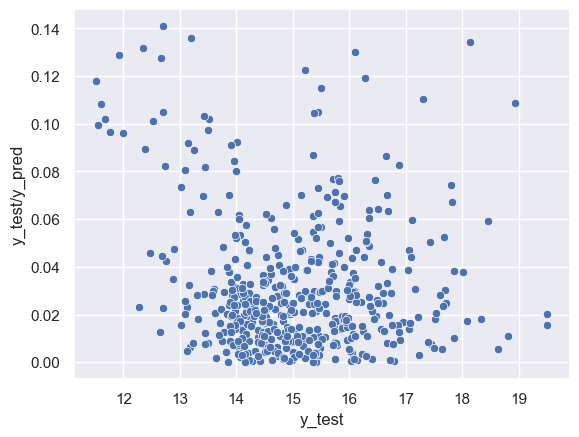

In [325]:
sns.scatterplot(y_test,abs(1-(y_test/y_pred))).set(xlabel='y_test',ylabel='y_test/y_pred')

## 3.9. Feature importance

A ce stade l'idée, est de detecter les features qui ont le plus d'importance dans les prédicitons. 

Eventuellement retirer quelques features qui ont peu d'importance

### 3.9.1 Reconstruction du dataset pour utilisation dans SHAP:

l'idée est de récuperer:
- le X_train transformé avec le nom des colonnes,
- ainsi que le'estimateur utilisé (et non l'ensemble du modèle) 

*note: quand je passe dans SHAP, mon best_estimator_, il y a un erreur car mon best estimator est un gridsearchCV, lui même contenant un pipeline.*

#### Décomposition du modèle


In [329]:
PREP=model['preprocessor']
PREP

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType', 'Neighborhood']),
                                ('num', 'passthrough',
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'has_parking', 'PropertyGFABuilding(s)',
                                  'Steam_use', 'Electricity_use', 'Gas_use',
                                  'ENERGYSTARScore'])])

In [330]:
IMP=model['imputer']

In [331]:
SCA=model['scaler']
SCA

RobustScaler()

In [332]:
EST=model['estimator']
EST

Ridge(alpha=5)

Récupération du nom des colonnes (après OneHotEncoder) 

In [333]:
feat=PREP.get_feature_names_out()
feat

array(['OneHot__PrimaryPropertyType_Distribution Center',
       'OneHot__PrimaryPropertyType_Entertainment',
       'OneHot__PrimaryPropertyType_Hospital',
       'OneHot__PrimaryPropertyType_Hotel',
       'OneHot__PrimaryPropertyType_K-12 School',
       'OneHot__PrimaryPropertyType_Laboratory',
       'OneHot__PrimaryPropertyType_Large Office',
       'OneHot__PrimaryPropertyType_Medical Office',
       'OneHot__PrimaryPropertyType_Office',
       'OneHot__PrimaryPropertyType_Other',
       'OneHot__PrimaryPropertyType_Parking',
       'OneHot__PrimaryPropertyType_Refrigerated Warehouse',
       'OneHot__PrimaryPropertyType_Residence Hall',
       'OneHot__PrimaryPropertyType_Restaurant',
       'OneHot__PrimaryPropertyType_Retail Store',
       'OneHot__PrimaryPropertyType_Self-Storage Facility',
       'OneHot__PrimaryPropertyType_Senior Care Community',
       'OneHot__PrimaryPropertyType_Small- and Mid-Sized Office',
       'OneHot__PrimaryPropertyType_Supermarket / Grocery Sto

In [98]:
#tmp=pd.DataFrame(PREP.fit_transform(X_log),columns=feat)

#### Reconstruction du dataframe qui sera utilisé par SHAP 

In [334]:
A=PREP.transform(X_train)
A=IMP.transform(A)
A=SCA.transform(A)
A=pd.DataFrame(A, columns=feat)
A.shape

(1126, 46)

#### Summary plot SHAP

In [335]:
explainer=shap.LinearExplainer(EST,A)
explainer

In [336]:
shap_values=explainer(A)

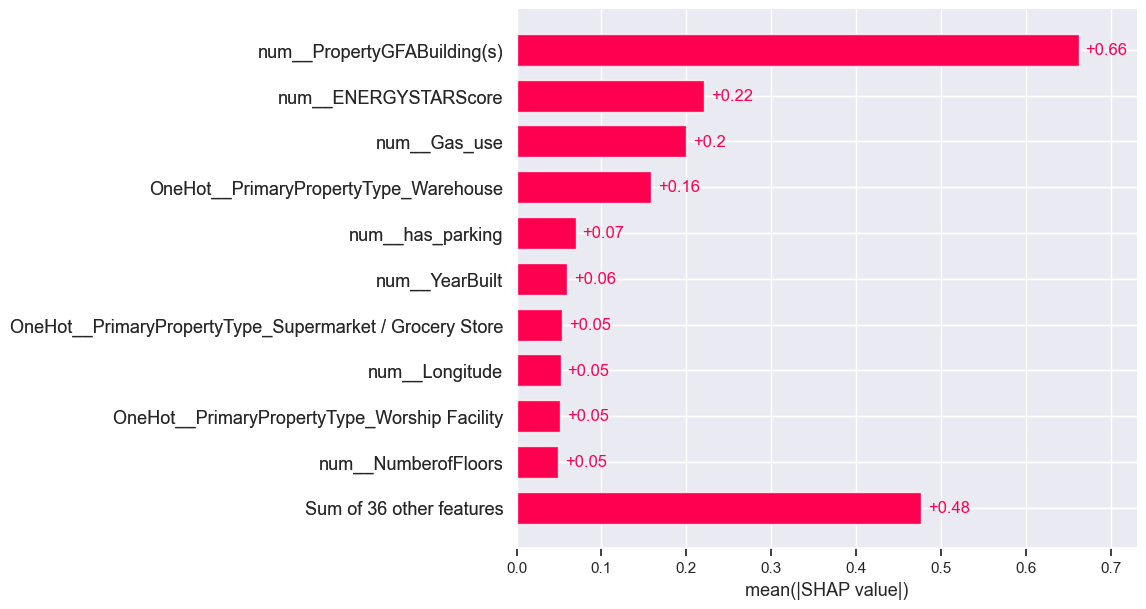

In [337]:
shap.plots.bar(shap_values, max_display= 11)

Globalement, la superficie du batiment est la variable qui explique le plus la conso en NRJ. 

On voit que l'ENERGYSTATScore est la 2 eme feature la plus importante. Raison de garder l'ENERGYSTARScore dans nos modèles de prédiction

On constate que les coordonnées géo n'ont que très peu d'importance dans la prédiciton. Je supprime les coordonnées dans la prochaine itération.

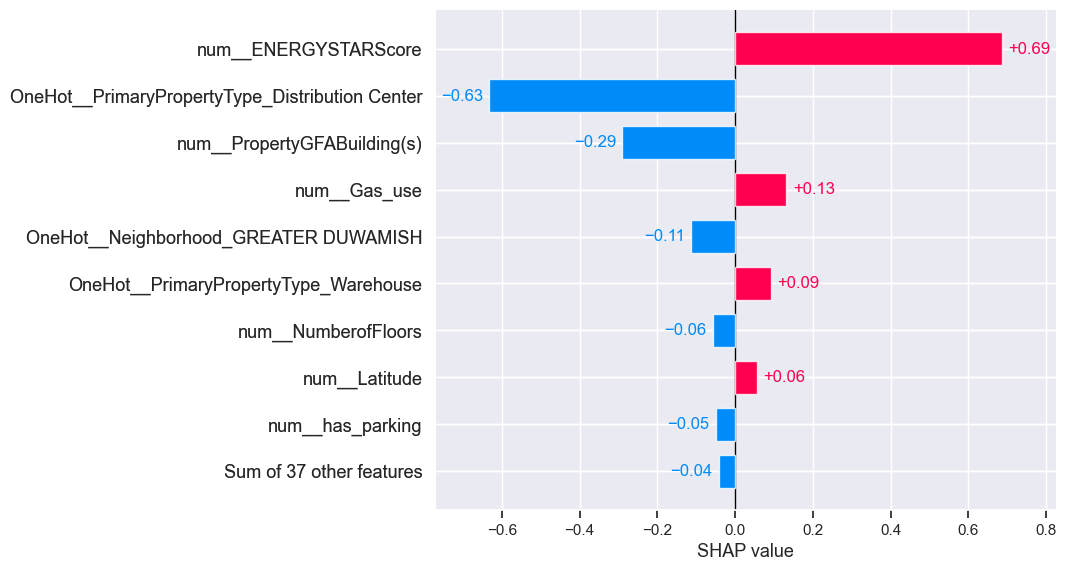

In [338]:
shap.plots.bar(shap_values[0])

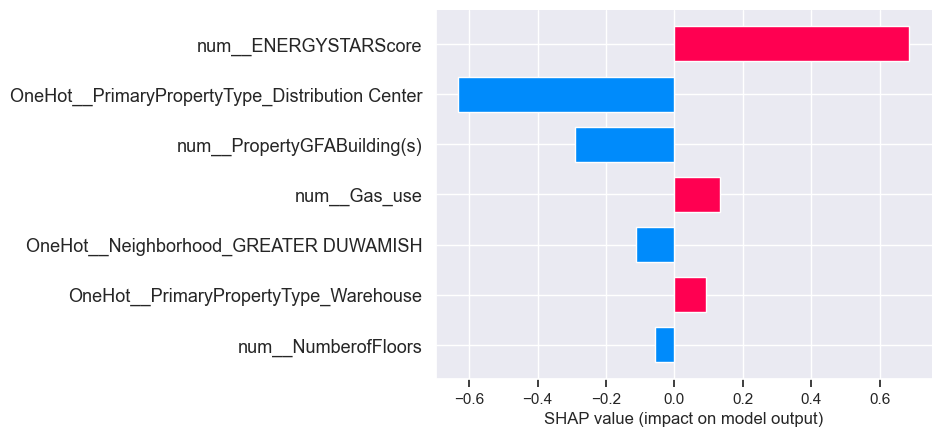

In [339]:
shap.bar_plot(explainer.shap_values(A.iloc[0]),
              feature_names=feat,)
             # max_display=len(feat))

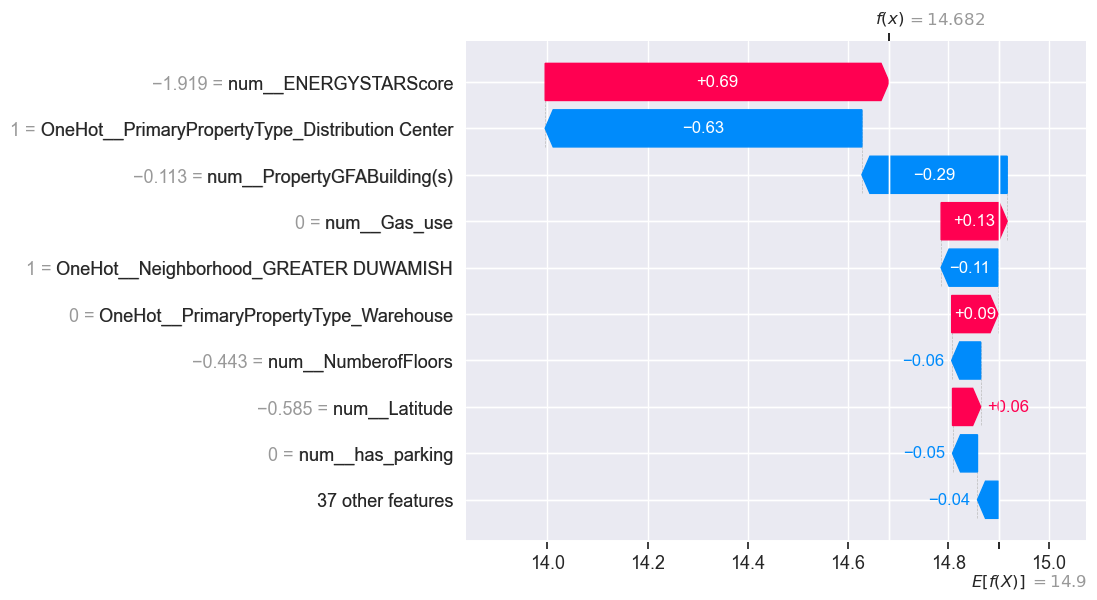

In [340]:
shap_values.feature_names = feat.tolist()
shap.waterfall_plot(shap_values[0])#, max_display=len(feat))

In [341]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(A.iloc[0]),
                feature_names=feat,
                out_names="Conso")

# 4. Amélioration avec Feature Engineering plus poussé et impact ENERGYSTARScore

## 4.1 Utlisation des features parking et type d'energie en %age (plutot qu'en booléen)

### Sur base df3, passage au log des features concernées

In [342]:
df3_log=df3.copy()

In [343]:
df3_log.columns

Index(['PrimaryPropertyType', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore',
       'superfice/etage', 'superfice/batiment', 'Parking_pct', 'pct_gaz',
       'pct_elec', 'pct_steam'],
      dtype='object')

In [344]:
col_log=['SiteEnergyUseWN(kBtu)',
'TotalGHGEmissions',
'NumberofBuildings',
'NumberofFloors',
'PropertyGFABuilding(s)',
'superfice/etage',
'superfice/batiment']

In [345]:
for col in col_log:
    df3_log[col]=np.log1p(df3[col])
df3_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore,superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,47.61220,-122.33799,1927,0.693147,2.564949,11.390023,15.824652,5.525373,60.0,8.905241,11.390023,0.000000,0.2,0.5,0.3
1,Hotel,47.61317,-122.33393,1996,0.693147,2.484907,11.390792,15.974742,5.693261,61.0,8.993009,11.390792,0.145453,0.6,0.4,0.0
2,Hotel,47.61393,-122.33810,1969,0.693147,3.737670,13.540275,18.118725,7.645053,43.0,9.826755,13.540275,0.205748,0.0,0.7,0.3
3,Hotel,47.61412,-122.33664,1926,0.693147,2.397895,11.023878,15.753792,5.660979,56.0,8.721439,11.023878,0.000000,0.3,0.4,0.3
4,Hotel,47.61375,-122.34047,1980,0.693147,2.944439,11.640272,16.500395,6.226556,75.0,8.750049,11.640272,0.353115,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,0.693147,1.945910,12.469448,17.530998,6.908815,NaN,10.677708,12.469448,0.246251,0.4,0.6,0.0
1605,University,47.66127,-122.31256,1962,0.693147,0.693147,11.128336,14.972650,3.142858,NaN,11.128336,11.128336,0.000000,0.0,1.0,0.0
1606,Entertainment,47.70541,-122.32232,2005,0.693147,0.693147,9.933871,13.364472,1.693779,NaN,9.933871,9.933871,0.000000,0.0,1.0,0.0
1607,Entertainment,47.63228,-122.31574,1912,0.693147,0.693147,10.062455,15.720053,5.561527,NaN,10.062455,10.062455,0.000000,0.8,0.2,0.0


### Adaptation de X_log

In [346]:
X_log=df3_log.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','Latitude','Longitude'],axis=1)
X_log

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,1927,0.693147,2.564949,11.390023,60.0,8.905241,11.390023,0.000000,0.2,0.5,0.3
1,Hotel,1996,0.693147,2.484907,11.390792,61.0,8.993009,11.390792,0.145453,0.6,0.4,0.0
2,Hotel,1969,0.693147,3.737670,13.540275,43.0,9.826755,13.540275,0.205748,0.0,0.7,0.3
3,Hotel,1926,0.693147,2.397895,11.023878,56.0,8.721439,11.023878,0.000000,0.3,0.4,0.3
4,Hotel,1980,0.693147,2.944439,11.640272,75.0,8.750049,11.640272,0.353115,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,2015,0.693147,1.945910,12.469448,NaN,10.677708,12.469448,0.246251,0.4,0.6,0.0
1605,University,1962,0.693147,0.693147,11.128336,NaN,11.128336,11.128336,0.000000,0.0,1.0,0.0
1606,Entertainment,2005,0.693147,0.693147,9.933871,NaN,9.933871,9.933871,0.000000,0.0,1.0,0.0
1607,Entertainment,1912,0.693147,0.693147,10.062455,NaN,10.062455,10.062455,0.000000,0.8,0.2,0.0


### Adaptation du pipeline

In [347]:
num_feat=X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'superfice/etage',
 'superfice/batiment',
 'Parking_pct',
 'pct_gaz',
 'pct_elec',
 'pct_steam']

In [348]:
cat_feat=X_log.select_dtypes(exclude=np.number).columns.to_list()
cat_feat

['PrimaryPropertyType']

In [349]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False),cat_feat),
                               ('num','passthrough',num_feat)
                               ]
                             )

In [350]:
pipeline=Pipeline([
    ('preprocessor',transformer),
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LinearRegression())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [351]:
param_grid={'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'],
 'estimator': [LinearRegression(),
  SGDRegressor(),
  Ridge(),
  Lasso(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
  SVR()]}

In [352]:
param_grid

{'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'],
 'estimator': [LinearRegression(),
  SGDRegressor(),
  Ridge(),
  Lasso(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
  SVR()]}

In [353]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_pct')
res

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
30,0.41,0.02,0.07,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",6.800000e-01,1.100000e-01,1,8.100000e-01,1.000000e-02,-4.000000e-01,5.000000e-02,1,-3.500000e-01,1.000000e-02,-3.700000e-01,1.000000e-01,1,-3.200000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
14,0.15,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",6.700000e-01,1.000000e-01,2,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,5,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,3,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
12,0.17,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",6.700000e-01,1.000000e-01,3,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,6,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,4,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
1,0.14,0.02,0.03,0.00,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",6.700000e-01,1.000000e-01,4,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,7,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,7,-3.500000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
10,0.15,0.01,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",6.700000e-01,1.000000e-01,5,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,3,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,2,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
8,0.17,0.02,0.03,0.00,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",6.700000e-01,1.000000e-01,6,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,4,-4.000000e-01,0.000000e+00,-3.800000e-01,9.000000e-02,5,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
13,0.15,0.01,0.04,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",6.700000e-01,1.000000e-01,7,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,8,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,6,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
4,0.17,0.03,0.03,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",6.700000e-01,1.000000e-01,8,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,9,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,8,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
2,0.14,0.01,0.03,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",6.700000e-01,1.000000e-01,9,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,12,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,9,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
0,0.14,0.02,0.03,0.01,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",6.700000e-01,1.000000e-01,10,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,10,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,10,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct


Lègere amélioration du R² (0.68) pour SVR, et Ridge, LR et SGDRegressor (0,67). Essayons d'améliorer les hyperparamètres pour ces 2 estimateurs:

#### SVR

In [354]:
param_grid={'scaler': [MinMaxScaler(),
  ],
 'estimator': [SVR(),
  ],
  'estimator__epsilon':[0,0.01, 0.05,0.2],
  'estimator__C':[1,2,3,5 ] 
           }

In [355]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_pct')
res

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__C,param_estimator__epsilon,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
3,0.35,0.02,0.06,0.00,"SVR(C=1, epsilon=0.2)",1,0.2,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.11,1,0.81,0.01,-0.40,0.05,7,-0.36,0.00,-0.37,0.10,1,-0.32,0.01,1,1,log + OneHot + NRJ_pct
7,0.35,0.01,0.06,0.00,"SVR(C=1, epsilon=0.2)",2,0.2,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.12,2,0.82,0.01,-0.40,0.05,4,-0.35,0.00,-0.37,0.10,2,-0.30,0.01,1,1,log + OneHot + NRJ_pct
11,0.36,0.01,0.06,0.00,"SVR(C=1, epsilon=0.2)",3,0.2,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.12,3,0.83,0.01,-0.41,0.05,9,-0.34,0.00,-0.37,0.10,3,-0.29,0.01,1,1,log + OneHot + NRJ_pct
15,0.39,0.02,0.06,0.00,"SVR(C=1, epsilon=0.2)",5,0.2,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.12,4,0.84,0.01,-0.41,0.05,13,-0.33,0.00,-0.37,0.10,4,-0.28,0.01,1,1,log + OneHot + NRJ_pct
2,0.42,0.02,0.08,0.01,"SVR(C=1, epsilon=0.2)",1,0.05,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.11,5,0.81,0.01,-0.40,0.05,3,-0.35,0.01,-0.37,0.09,5,-0.32,0.01,1,1,log + OneHot + NRJ_pct
1,0.45,0.03,0.09,0.01,"SVR(C=1, epsilon=0.2)",1,0.01,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.11,6,0.81,0.01,-0.40,0.05,2,-0.35,0.01,-0.37,0.09,7,-0.32,0.01,1,1,log + OneHot + NRJ_pct
0,0.47,0.02,0.09,0.01,"SVR(C=1, epsilon=0.2)",1,0,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.11,7,0.81,0.01,-0.40,0.05,1,-0.35,0.01,-0.37,0.09,6,-0.32,0.01,1,1,log + OneHot + NRJ_pct
6,0.43,0.02,0.08,0.01,"SVR(C=1, epsilon=0.2)",2,0.05,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.12,8,0.82,0.01,-0.40,0.05,5,-0.34,0.01,-0.37,0.10,8,-0.30,0.01,1,1,log + OneHot + NRJ_pct
5,0.46,0.02,0.09,0.01,"SVR(C=1, epsilon=0.2)",2,0.01,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.68,0.12,9,0.82,0.01,-0.40,0.05,6,-0.33,0.00,-0.37,0.10,9,-0.30,0.01,1,1,log + OneHot + NRJ_pct
4,0.48,0.01,0.09,0.01,"SVR(C=1, epsilon=0.2)",2,0,MinMaxScaler(),"{'estimator': SVR(C=1, epsilon=0.2), 'estimato...",0.67,0.12,10,0.82,0.01,-0.40,0.05,8,-0.33,0.00,-0.37,0.10,10,-0.30,0.01,1,1,log + OneHot + NRJ_pct


Pas d'amélioration

In [356]:
#model=grid.best_estimator_
#model

#### SGD Regressor

In [357]:
param_grid={'scaler': [
    StandardScaler(),
  'passthrough'
  ],
 'estimator': [SGDRegressor(),
  ],
  'estimator__eta0':np.linspace(0.01,0.5,11)
           }

In [358]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_pct')
res

Fitting 10 folds for each of 22 candidates, totalling 220 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__eta0,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.15,0.02,0.03,0.01,SGDRegressor(),0.01,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",6.700000e-01,1.000000e-01,1,7.900000e-01,1.000000e-02,-4.200000e-01,5.000000e-02,1,-4.000000e-01,1.000000e-02,-3.800000e-01,9.000000e-02,1,-3.600000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
2,0.16,0.01,0.03,0.00,SGDRegressor(),0.059,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",6.400000e-01,1.100000e-01,2,7.700000e-01,1.000000e-02,-4.400000e-01,5.000000e-02,2,-4.200000e-01,1.000000e-02,-4.100000e-01,9.000000e-02,2,-3.800000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
4,0.18,0.03,0.03,0.01,SGDRegressor(),0.108,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.626416e+20,4.879249e+20,3,-2.445165e+19,7.335495e+19,-7.731817e+08,2.319438e+09,3,-2.656874e+08,7.970244e+08,-1.833107e+20,5.499321e+20,3,-4.111290e+19,1.233387e+20,1,1,log + OneHot + NRJ_pct
10,0.20,0.02,0.03,0.01,SGDRegressor(),0.255,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.833594e+21,8.498145e+21,4,-1.097553e+21,3.290929e+21,-8.101105e+09,2.325475e+10,4,-5.942449e+09,1.683359e+10,-3.151821e+21,9.452301e+21,4,-1.730922e+21,5.189849e+21,1,1,log + OneHot + NRJ_pct
6,0.17,0.01,0.03,0.01,SGDRegressor(),0.157,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.349119e+22,1.422108e+22,5,-1.016185e+22,4.178421e+21,-5.465927e+10,2.877680e+10,6,-4.240312e+10,1.962684e+10,-2.937964e+22,2.342832e+22,5,-1.712259e+22,7.154767e+21,1,1,log + OneHot + NRJ_pct
12,0.20,0.04,0.03,0.01,SGDRegressor(),0.304,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-2.715276e+22,2.672161e+22,6,-1.441986e+22,1.567193e+22,-5.256363e+10,4.400953e+10,5,-3.996112e+10,3.735810e+10,-3.818369e+22,4.407544e+22,6,-2.416802e+22,2.639236e+22,1,1,log + OneHot + NRJ_pct
8,0.16,0.02,0.03,0.01,SGDRegressor(),0.206,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-7.464025e+22,5.936184e+22,7,-3.501331e+22,2.524310e+22,-1.040747e+11,7.733389e+10,7,-8.369251e+10,5.231702e+10,-9.265589e+22,8.683726e+22,7,-5.840826e+22,4.213526e+22,1,1,log + OneHot + NRJ_pct
14,0.18,0.02,0.03,0.00,SGDRegressor(),0.353,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-8.363948e+22,5.623408e+22,8,-3.818262e+22,1.164759e+22,-1.215127e+11,6.594225e+10,8,-9.750124e+10,3.419476e+10,-1.022248e+23,7.839150e+22,8,-6.401707e+22,1.907290e+22,1,1,log + OneHot + NRJ_pct
16,0.18,0.02,0.03,0.01,SGDRegressor(),0.402,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.028265e+23,6.609171e+22,9,-5.404449e+22,1.951699e+22,-1.316154e+11,4.895096e+10,9,-1.200438e+11,3.711125e+10,-1.163377e+23,6.937053e+22,9,-9.073764e+22,3.258909e+22,1,1,log + OneHot + NRJ_pct
18,0.17,0.01,0.03,0.01,SGDRegressor(),0.451,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",-1.577893e+23,7.010854e+22,10,-8.217352e+22,1.603498e+22,-2.107723e+11,8.269024e+10,10,-1.759804e+11,4.740244e+10,-1.888169e+23,9.605216e+22,10,-1.374439e+23,2.301563e+22,1,1,log + OneHot + NRJ_pct


Pas d'amélioration

#### Ridge

In [359]:
param_grid={'scaler': [MinMaxScaler(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'
  ],
 'estimator': [Ridge(),
  ],
  'estimator__alpha':[5,100,200,500]
           }

In [360]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_pct')
res

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
2,0.15,0.01,0.03,0.01,Ridge(alpha=5),5,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.67,0.10,1,0.79,0.01,-0.42,0.05,2,-0.40,0.01,-0.38,0.09,1,-0.36,0.01,1,1,log + OneHot + NRJ_pct
6,0.16,0.01,0.03,0.01,Ridge(alpha=5),100,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.67,0.10,2,0.79,0.01,-0.42,0.05,1,-0.41,0.01,-0.38,0.09,2,-0.36,0.01,1,1,log + OneHot + NRJ_pct
1,0.20,0.05,0.03,0.01,Ridge(alpha=5),5,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.67,0.10,3,0.79,0.01,-0.42,0.05,4,-0.41,0.01,-0.38,0.09,3,-0.36,0.01,1,1,log + OneHot + NRJ_pct
3,0.16,0.02,0.03,0.01,Ridge(alpha=5),5,passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.67,0.10,4,0.79,0.01,-0.42,0.05,3,-0.41,0.01,-0.38,0.09,4,-0.36,0.01,1,1,log + OneHot + NRJ_pct
10,0.15,0.01,0.04,0.01,Ridge(alpha=5),200,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.67,0.10,5,0.78,0.01,-0.42,0.05,6,-0.41,0.01,-0.39,0.09,5,-0.36,0.01,1,1,log + OneHot + NRJ_pct
0,0.16,0.02,0.03,0.01,Ridge(alpha=5),5,MinMaxScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.67,0.10,6,0.78,0.01,-0.42,0.05,5,-0.41,0.01,-0.39,0.09,6,-0.36,0.01,1,1,log + OneHot + NRJ_pct
14,0.16,0.02,0.03,0.01,Ridge(alpha=5),500,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.64,0.10,7,0.77,0.01,-0.44,0.04,7,-0.43,0.00,-0.41,0.08,7,-0.39,0.01,1,1,log + OneHot + NRJ_pct
5,0.16,0.01,0.03,0.01,Ridge(alpha=5),100,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.59,0.10,8,0.73,0.01,-0.48,0.06,8,-0.47,0.01,-0.48,0.11,8,-0.46,0.01,1,1,log + OneHot + NRJ_pct
7,0.15,0.02,0.03,0.00,Ridge(alpha=5),100,passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.59,0.11,9,0.72,0.01,-0.48,0.06,9,-0.47,0.01,-0.48,0.11,9,-0.46,0.01,1,1,log + OneHot + NRJ_pct
9,0.18,0.02,0.03,0.01,Ridge(alpha=5),200,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.55,0.11,10,0.70,0.01,-0.51,0.06,10,-0.50,0.01,-0.53,0.11,10,-0.51,0.01,1,1,log + OneHot + NRJ_pct


Modèle retenu: R² inférieur à SVR mais fit time 2 fois plus rapide

In [361]:
model=grid.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

### Courbe d'apprentissage

In [165]:
from sklearn.model_selection import learning_curve

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Text(0.5, 1.0, "Courbe d'apprentissage / Consommation")

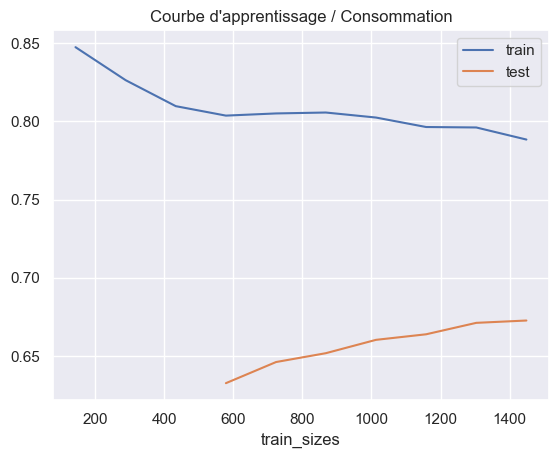

In [180]:
N,train_score,test_score=learning_curve(model,X_log,y_log,train_sizes=np.linspace(0.1,1,10), cv=10)
plt.plot(N,train_score.mean(axis=1),label = 'train')
plt.plot(N,test_score.mean(axis=1), label='test')
plt.xlabel('train_sizes')
plt.legend()
plt.title("Courbe d'apprentissage / Consommation")

### Représentation graphique des performance (y_pred vs y_test)

Entrainement du meilleur modèle via Train/Test Split

In [362]:
X_train, X_test,y_train,y_test=train_test_split(X_log,y_log,test_size=0.3)
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (1126, 12)
Test set: (483, 12)
Train target: (1126,)
Test target: (483,)


In [363]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [364]:
model.score(X_train,y_train)

0.8038215456502611

In [365]:
model.score(X_test,y_test)

0.7399396376506562

In [366]:
y_pred=model.predict(X_test)

#### Représentation graphique

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


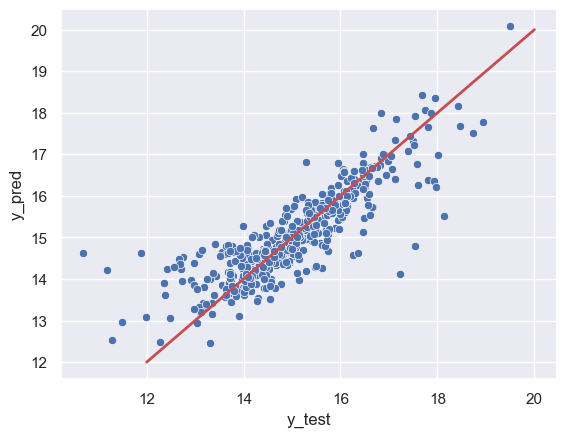

In [367]:
sns.scatterplot(y_test,y_pred).set(xlabel='y_test',ylabel='y_pred')
plt.plot([12.0, 20.0], [12.0, 20.0], 'r-', lw=2)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


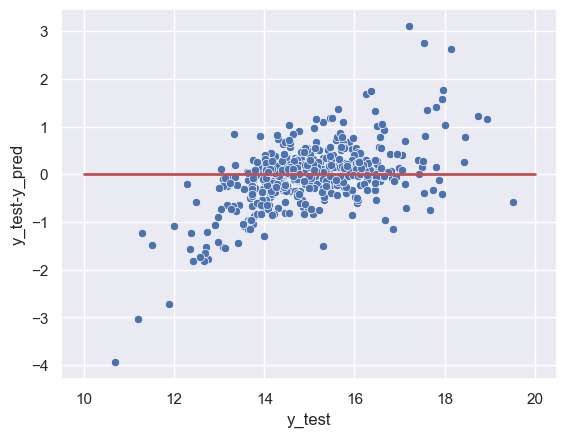

In [368]:
sns.scatterplot(y_test,y_test-y_pred).set(xlabel='y_test',ylabel='y_test-y_pred')
plt.plot([10.0, 20.0], [0.0, 0.0], 'r-', lw=2)

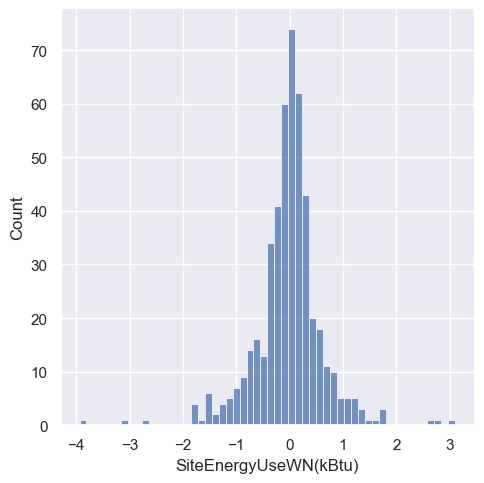

In [369]:
sns.displot(y_test-y_pred)

Dans cette version du modèle, on constate encore une fois que les predictions sont moins fiables sur les valeurs extremes

## 4.2 Feature importance

### 4.2.1 Reconstruction du dataset pour utilisation dans SHAP:

l'idée est de récuperer:
- le X_train transformé avec le nom des colonnes,
- ainsi que le'estimateur utilisé (et non l'ensemble du modèle) 

*note: quand je passe dans SHAP, mon best_estimator_, il y a un erreur car mon best estimator est un gridsearchCV, lui même contenant un pipeline.*

#### 4.2.1.1 Récupération du meilleur modèle => Ridge() 
=> Model


In [370]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [371]:
    model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [372]:
model.score(X_test,y_test)

0.7399396376506562

In [373]:
model.score(X_train,y_train)

0.8038215456502611

Décomposition du modèle:

In [374]:
PREP=model['preprocessor']
PREP

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFABuilding(s)',
                                  'ENERGYSTARScore', 'superfice/etage',
                                  'superfice/batiment', 'Parking_pct',
                                  'pct_gaz', 'pct_elec', 'pct_steam'])])

In [375]:
IMP=model['imputer']

In [376]:
SCA=model['scaler']
SCA

StandardScaler()

In [377]:
EST=model['estimator']
EST

Ridge(alpha=5)

Récupération du nom des colonnes (après OneHotEncoder) 

In [378]:
feat=PREP.get_feature_names_out()
feat

array(['OneHot__PrimaryPropertyType_Distribution Center',
       'OneHot__PrimaryPropertyType_Entertainment',
       'OneHot__PrimaryPropertyType_Hospital',
       'OneHot__PrimaryPropertyType_Hotel',
       'OneHot__PrimaryPropertyType_K-12 School',
       'OneHot__PrimaryPropertyType_Laboratory',
       'OneHot__PrimaryPropertyType_Large Office',
       'OneHot__PrimaryPropertyType_Medical Office',
       'OneHot__PrimaryPropertyType_Office',
       'OneHot__PrimaryPropertyType_Other',
       'OneHot__PrimaryPropertyType_Parking',
       'OneHot__PrimaryPropertyType_Refrigerated Warehouse',
       'OneHot__PrimaryPropertyType_Residence Hall',
       'OneHot__PrimaryPropertyType_Restaurant',
       'OneHot__PrimaryPropertyType_Retail Store',
       'OneHot__PrimaryPropertyType_Self-Storage Facility',
       'OneHot__PrimaryPropertyType_Senior Care Community',
       'OneHot__PrimaryPropertyType_Small- and Mid-Sized Office',
       'OneHot__PrimaryPropertyType_Supermarket / Grocery Sto

#### Reconstruction du dataframe qui sera utilisé par SHAP 

In [379]:
A=PREP.transform(X_train)
A=IMP.transform(A)
A=SCA.transform(A)
A=pd.DataFrame(A, columns=feat)
A.shape

(1126, 33)

#### Summary plot SHAP

In [381]:
explainer=shap.LinearExplainer(EST,A)
explainer

In [382]:
shap_values=explainer(A)

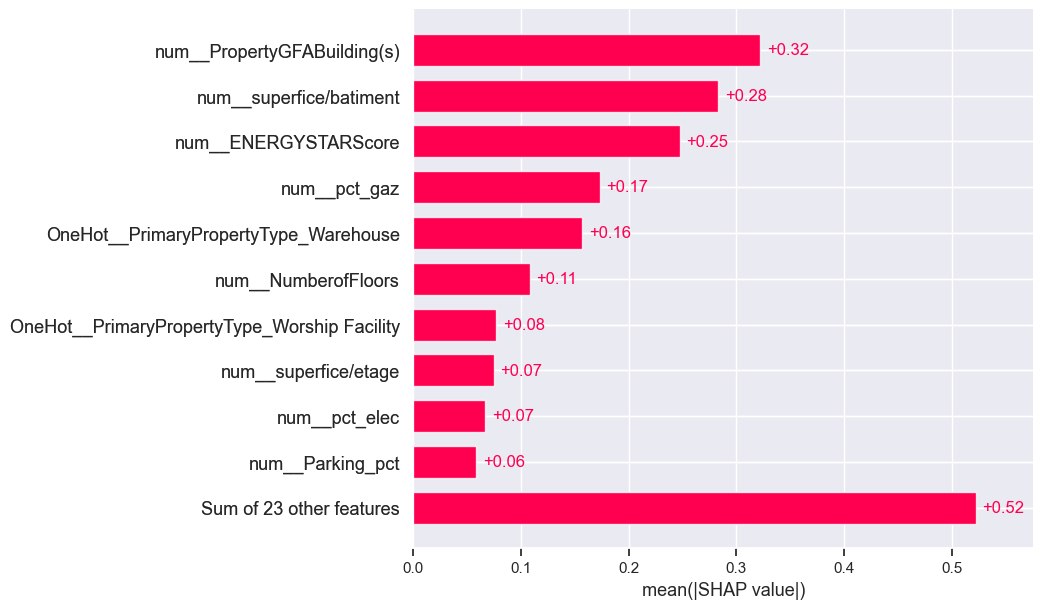

In [383]:
shap.plots.bar(shap_values, max_display= 11)

Pour ce modèle, la superficie du batiment est encore la variable qui explique le plus la conso en NRJ. 

Suivie de la superficie par batiment (logique si on considère que la plupart des 'Property n'ont qu'un seul bâtiment'.

L'ENERGYSTARScore est toujorus bien placé

Vérifion ç l'aide d'un GridSearchCV le delta dans les résultats du modèle avec et sans ENERGYSTARScore

## 4.3 Impact de l'energy score

Adaptation du dataset X_log

In [384]:
X_log=X_log.drop(['ENERGYSTARScore'],axis=1)
X_log

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,1927,0.693147,2.564949,11.390023,8.905241,11.390023,0.000000,0.2,0.5,0.3
1,Hotel,1996,0.693147,2.484907,11.390792,8.993009,11.390792,0.145453,0.6,0.4,0.0
2,Hotel,1969,0.693147,3.737670,13.540275,9.826755,13.540275,0.205748,0.0,0.7,0.3
3,Hotel,1926,0.693147,2.397895,11.023878,8.721439,11.023878,0.000000,0.3,0.4,0.3
4,Hotel,1980,0.693147,2.944439,11.640272,8.750049,11.640272,0.353115,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,2015,0.693147,1.945910,12.469448,10.677708,12.469448,0.246251,0.4,0.6,0.0
1605,University,1962,0.693147,0.693147,11.128336,11.128336,11.128336,0.000000,0.0,1.0,0.0
1606,Entertainment,2005,0.693147,0.693147,9.933871,9.933871,9.933871,0.000000,0.0,1.0,0.0
1607,Entertainment,1912,0.693147,0.693147,10.062455,10.062455,10.062455,0.000000,0.8,0.2,0.0


Adaptation du pipeline

In [385]:
num_feat=X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'superfice/etage',
 'superfice/batiment',
 'Parking_pct',
 'pct_gaz',
 'pct_elec',
 'pct_steam']

In [386]:
transformer= ColumnTransformer(transformers=
                               [
                               ('OneHot',OneHotEncoder(sparse=False),cat_feat),
                               ('num','passthrough',num_feat)
                               ]
                             )
transformer

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFABuilding(s)',
                                  'superfice/etage', 'superfice/batiment',
                                  'Parking_pct', 'pct_gaz', 'pct_elec',
                                  'pct_steam'])])

In [387]:
pipeline=Pipeline([
    ('preprocessor',transformer),
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()),
    ('estimator',LinearRegression())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                                   'pct_steam'])])),
                ('imputer', KNNImputer()), ('s

In [388]:
param_grid={'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'],
 'estimator': [LinearRegression(),
  SGDRegressor(),
  Ridge(),
  Lasso(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
  SVR()]}

In [389]:
grid=GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='r2')
grid.fit(X_log,y_log)
res=result(grid,log_target=1,transf_feat=1,features='log + OneHot + NRJ_pct - NRJScore')
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
30,0.26,0.01,0.05,0.0,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.61,0.12,1,0.77,0.01,-0.47,0.05,1,-0.42,0.01,-0.45,0.09,1,-0.39,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
1,0.01,0.00,0.01,0.0,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.61,0.11,2,0.74,0.01,-0.48,0.05,6,-0.47,0.01,-0.46,0.09,3,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
14,0.01,0.00,0.01,0.0,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.60,0.11,3,0.74,0.01,-0.48,0.05,5,-0.47,0.01,-0.46,0.09,4,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
10,0.01,0.00,0.01,0.0,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.60,0.11,4,0.74,0.01,-0.48,0.04,3,-0.47,0.01,-0.46,0.09,2,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
12,0.02,0.00,0.01,0.0,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.60,0.11,5,0.74,0.01,-0.48,0.05,4,-0.47,0.01,-0.46,0.09,5,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
8,0.02,0.00,0.01,0.0,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.60,0.11,6,0.74,0.01,-0.48,0.05,7,-0.47,0.01,-0.46,0.09,6,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
13,0.01,0.00,0.01,0.0,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.60,0.11,7,0.74,0.01,-0.48,0.05,8,-0.47,0.01,-0.46,0.09,7,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
4,0.02,0.01,0.01,0.0,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.60,0.11,8,0.74,0.01,-0.49,0.05,9,-0.47,0.01,-0.46,0.09,8,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
2,0.02,0.00,0.01,0.0,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.60,0.11,9,0.74,0.01,-0.49,0.04,11,-0.47,0.01,-0.46,0.09,9,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
0,0.01,0.00,0.01,0.0,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.60,0.11,10,0.74,0.01,-0.49,0.04,12,-0.47,0.01,-0.46,0.09,10,-0.43,0.01,1,1,log + OneHot + NRJ_pct - NRJScore


Baisse du R² de 5 à 6 points selon les estimateurs.

In [391]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending =False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
146,0.53,0.06,0.10,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,7,0.82,0.01,-0.44,0.05,2,-0.34,0.00,-0.40,0.10,7,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN
140,0.54,0.05,0.11,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,1,0.84,0.01,-0.44,0.05,6,-0.31,0.00,-0.40,0.10,4,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN
145,0.74,0.36,0.08,0.02,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,6,0.84,0.01,-0.44,0.05,7,-0.34,0.00,-0.40,0.09,2,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN
144,0.51,0.03,0.12,0.09,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,5,0.84,0.01,-0.44,0.05,4,-0.32,0.00,-0.40,0.10,3,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN
143,0.52,0.02,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,4,0.84,0.01,-0.44,0.05,5,-0.31,0.00,-0.40,0.10,5,-0.27,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN
142,0.53,0.06,0.10,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,3,0.82,0.01,-0.44,0.05,1,-0.34,0.00,-0.40,0.10,6,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN
141,0.50,0.07,0.09,0.01,"SVR(C=2, epsilon=0)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0), 'estimator_...",0.66,0.10,2,0.82,0.01,-0.44,0.04,3,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN
111,0.17,0.02,0.04,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.65,0.10,7,0.78,0.01,-0.45,0.05,7,-0.43,0.01,-0.41,0.11,7,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
105,0.43,0.01,0.08,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.65,0.10,1,0.82,0.01,-0.44,0.04,1,-0.35,0.00,-0.40,0.10,1,-0.30,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN
157,0.17,0.02,0.03,0.01,Ridge(alpha=5),passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.11,2,0.78,0.01,-0.45,0.05,2,-0.43,0.01,-0.41,0.11,2,-0.37,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,5,NaN


Confirmation de l'importance de l'ENERGYSTARScore dans la prédiction de la consommation energétique